# Load packages

In [1]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
            
from scipy import optimize
from scipy.optimize import minimize
from scipy.stats import gumbel_r
from matplotlib.pyplot import cm
import math
import matplotlib
import matplotlib.colors as mcolors
from scipy.optimize import fsolve

import sympy
from sympy import *
from sympy import symbols, Eq, solve
from shapely.geometry import LineString


%matplotlib inline
# plt.style.use('ggplot')
import warnings
from scipy.stats import pearsonr
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import seaborn as sns


output = 'Output47'
Input = 'Input21'

colors2 = ['#6CC24A','#FFB81C', '#A50034'] # groen geel rood
colors = ['#0098FA', '#0167A9', '#002C48'] # blauw blauw blauw
colors4 = [ '#A50034', '#FFB81C', '#6CC24A'] # rood geel groen
c3 = ['#009B77', '#6CC24A', '#FFB81C', '#EC6842', '#A50034', '#6F1D77', '#EF60A3'] # groen groen geel oranjerood paarsrood paars roze
c4 = ['#6CC24A', '#FFB81C', '#EC6842', '#A50034', '#6F1D77'] # groen geel oranjerood paarsrood paars

# Catchment descriptors

In [2]:
#HAI
def HAI_calculate(temp, precipitation):

    temp_adjusted = np.zeros(12)
    
    for i in range(1,13):
        if temp[i] < 0:
            temp_adjusted[i-1] = 0
        elif temp[i] > 30:
            temp_adjusted[i-1] = 30
        else:
            temp_adjusted[i-1] = temp[i]            
        
    T = np.sum(temp_adjusted)
    HAI = (58.93 * (T/12))/precipitation
    
    return HAI

#Function for the Seasonality Index
def Seasonality_index(Annual_mean, Monthly_mean):
    SI = (1/Annual_mean) * np.sum(np.abs(Monthly_mean - (Annual_mean/12)))
    
    return SI

#Function for Seasonality Timing Index
def ST_calc(dP,dT):
    days = 366
    ST = dP[0] * np.sign(dT[0]) * np.cos((np.pi * (dP[1] - dT[1]))/days)
    return ST

#Functions to compute Seasonal variability indexes
def T_daily(dT):
    t = np.linspace(1,366,366)
    days = 366
    T = T_mean + dT[0] * np.sin((2*np.pi * (t-dT[1]))/days)
    return T

def Cal_T_daily(dT):
    days = 366
    T_calc = T_daily(dT)
    
    return (np.sum(np.abs(T_calc - T_obs)))/days

def P_daily(dP):
    t = np.linspace(1,366,366)
    days = 366
    P = P_mean * (1 + dP[0] * np.sin((2*np.pi * (t-dP[1]))/days))
    return P

def Cal_P_daily(dP):
    days = 366
    P_calc = P_daily(dP)
    
    return (np.sum(np.abs(P_calc - P_obs)))/days

def E_daily(dE):
#    t = np.linspace(1,366,366)
    t = np.linspace(1,366,366)

    days = 366
    E = E_mean * (1 + dE[0] * np.sin((2*np.pi * (t-dE[1]))/days))
    return E

def Cal_E_daily(dE):
    days = 366
    E_calc = E_daily(dE)
    
    return (np.sum(np.abs(E_calc - E_obs)))/days

#Function for the interstorm duration or low_prec_freq
def Interstorm_duration(P):
    interstorm = []
    count = 0

    for j in range(len(P)):
        if P[j] < 1:
            count += 1
        elif P[j] >= 1 and count > 0:
            interstorm.append(count)
            count = 0 
    interstorm_duration = np.mean(interstorm)
    return interstorm_duration

#Function to compute the root-zone storage capacity
def rootzone(df_out, RP):
    # firstyear = df_out['hydroyear'].iloc[0]
    # lastyear = df_out['hydroyear'].iloc[-1]
    # df_out = df_out.drop(df_out[df_out['hydroyear']==firstyear].index)
    # df_out = df_out.drop(df_out[df_out['hydroyear']==lastyear].index)
    years = df_out.groupby(['hydroyear'])
    SD = years['SD_sum'].max() - years['SD_sum'].min()
    var = gumbel_r.fit(SD)
    p = 1-1/RP
    Sr = gumbel_r.ppf(p, var[0],var[1])
    return(Sr, df_out)




#Functions to compute the precipitation variability
def most_common(lst):
    return max(set(lst), key=lst.count)


#compute frequency, duration and timing of high and low precipitation.
def freq_dur_tim_calc(data):
    count_high = 0
    count_low = 0
    mean_daily_P = data['prec_subcatch'].mean()

    colum = np.zeros(len(data))
    data['high_daily_P'] = colum
    list_dur_high = []
    list_tim_high = []
    data['low_daily_P'] = colum
    list_dur_low = []
    list_tim_low = []


    for i in range(1, len(data)):
        if data['prec_subcatch'][i] >= 5*mean_daily_P:
                data['high_daily_P'][i] = 1
                count_high +=1
        if data['high_daily_P'][i] == 0.0 and data['high_daily_P'][i-1] == 1:
                list_dur_high.append(count_high)
                list_tim_high.append(data['dt'].dt.month[i])
                count_high = 0   



        if data['prec_subcatch'][i] <= 1:
                data['low_daily_P'][i] = 1
                count_low += 1

        if data['low_daily_P'][i] == 0.0 and data['low_daily_P'][i-1] == 1:
                list_dur_low.append(count_low)
                list_tim_low.append(data['dt'].dt.month[i])
                count_low = 0


    data_high_P = data['high_daily_P'].resample('A').sum()
    data_low_P = data['low_daily_P'].resample('A').sum()

    high_prec_freq = data_high_P.mean()
    low_prec_freq = data_low_P.mean()
    
    high_prec_dur = np.mean(list_dur_high)
    low_prec_dur  = np.mean(list_dur_low)
    
    month_high = most_common(list_tim_high)
    month_low = most_common(list_tim_low)

    high_prec_tim = month_calc(month_high)
    low_prec_tim  = month_calc(month_low)
    
    
    return high_prec_freq, high_prec_dur, high_prec_tim, low_prec_freq, low_prec_dur, low_prec_tim

def month_calc(month):
    if month == 12 or month == 1 or month == 2:
        return 1
    elif month == 3 or month == 4 or month == 5:
        return 2

    elif month == 6 or month == 7 or month == 8:
        return 3
    elif month == 9 or month == 10 or month == 11:
        return 4
    
def w_function(AI, w):
    EI = 1 + AI - (1 + AI**w)**(1/w)
    return EI

# Load data 

### Data preparation

##### Fix St pieter

In [3]:
# dataq = pd.read_csv("1_Data/SintPieter/SPW_Q_MAASTRICHT2.csv", delimiter=',', parse_dates=[0], skipinitialspace=True)
# Albert = pd.read_csv("1_Data/SintPieter/Kanne_Albertkl_Afvoer/Kanne_Albertkl_Afvoer_v2.csv", delimiter = ';')
# df_LB = pd.read_csv("1_Data/SintPieter/ST_PIETER_AlbertCanal.csv")

# df_LB['timestamp'] = pd.to_datetime(df_LB['timestamp'])
# df_LB = df_LB.set_index('timestamp')
# df_LB_daily = df_LB.resample('D').mean()
# display(df_LB_daily)

# Albert['timestamp'] = pd.to_datetime(Albert['timestamp'], utc=True)
# Albert = Albert.set_index(pd.to_datetime(Albert['timestamp']))
# Albert.index = pd.DatetimeIndex(Albert.index)
# Albert = Albert.resample('D').sum()


# Albert = Albert.loc["1999-01-01":"2018-12-31","Value"]
# Albert = Albert.loc["1999-01-01":"2018-12-31"]

# for i in range(len(dataq)):
#     Q_kanne = Albert[i]
#     if Q_kanne < 0:
#         Q_kanne = 0 
#     dataq.loc[i, 'Q St Pieter'] = dataq.loc[i, 'Q St Pieter'] + Q_kanne
    
# dataq.to_csv('1_Data/SPW_names/SPW_Q_MAASTRICHT.csv', index=False)

In [4]:
df_meuse = pd.read_excel("1_Data/Stations_Meuse.xlsx")
meuse_names = df_meuse["Read"]

df_meuse_be = pd.read_excel("1_Data/Stations_Meuse_be.xlsx")
meuse_names_be = df_meuse_be["Read"]

In [5]:
for i in range(len(df_meuse)):
    w_flow = df_meuse.loc[i]["Wflow_ID"]
    series = pd.read_csv("1_Data/final/"+str(w_flow)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    series.to_csv("1_Data/final_names/"+str(df_meuse.loc[i]["Read"].strip())+str(".csv"))

#### Dictorionairies

In [6]:
fr_dict = dict([
    ("La Meuse à Goncourt", "La Meuse Goncourt"),
    ("Le Mouzon à Circourt-sur-Mouzon [Villars]", "Le Mouzon Circourt-sur-Mouzon [Villars]"),
    ("Le Vair à Soulosse-sous-Saint-Élophe", "Le Vair Soulosse-sous-Saint-Élophe"),
    ("La Meuse à Saint-Mihiel", "La Meuse Saint-Mihiel"),
    ("La Meuse à Stenay", "La Meuse Stenay"),
    ("La Chiers à Longlaville", "La Chiers Longlaville"),
    ("La Crusnes à Pierrepont", "La Crusnes Pierrepont"),
    ("Le Ton à Écouviez", "Le Ton Écouviez"),
    ("Le Loison à Han-lès-Juvigny", "Le Loison Han-lés-Juvigny"),
    ("La Chiers à Carignan", "La Chiers Carignan"),
    ("La Bar à Cheveuges", "La Bar Cheveuges"),
    ("La Vence à la Francheville", "La Vence la Francheville"),
    ("La Sormonne à Belval", "La Sormonne Belval"),
    ("La Meuse à Chooz", "Chooz"),
])

fr_dict_inv = dict([
    ("La Meuse Goncourt", "La Meuse à Goncourt"),
    ("Le Mouzon Circourt-sur-Mouzon [Villars]", "Le Mouzon à Circourt-sur-Mouzon [Villars]",),
    ("Le Vair Soulosse-sous-Saint-Élophe", "Le Vair à Soulosse-sous-Saint-Élophe"),
    ("La Meuse Saint-Mihiel", "La Meuse à Saint-Mihiel"),
    ("La Meuse Stenay", "La Meuse à Stenay"),
    ("La Chiers Longlaville", "La Chiers à Longlaville"),
    ("La Crusnes Pierrepont", "La Crusnes à Pierrepont"),    
    ("Le Ton Écouviez", "Le Ton à Écouviez"),
    ("Le Loison Han-lés-Juvigny", "Le Loison à Han-lès-Juvigny"),
    ("La Chiers Carignan", "La Chiers à Carignan"),
    ("La Bar Cheveuges", "La Bar à Cheveuges"),
    ("La Vence la Francheville", "La Vence à la Francheville"),
    ("La Sormonne Belval", "La Sormonne à Belval"),
    ("Chooz", "La Meuse à Chooz"),
])

fr_dict_code = dict([
    ("B0220010", "La Meuse Goncourt"),
    ("B1092010", "Le Mouzon Circourt-sur-Mouzon [Villars]"),
    ("B1282010", "Le Vair Soulosse-sous-Saint-Élophe"),
    ("B2220010", "La Meuse Saint-Mihiel"),
    ("B3150020", "La Meuse Stenay"),
    ("B4001010", "La Chiers Longlaville"),
    ("B4132010", "La Crusnes Pierrepont"),
    ("B4224310", "Le Ton Écouviez"),
    ("B4572010", "Le Loison Han-lés-Juvigny"),
    ("B4631010", "La Chiers Carignan"),
    ("B5172010", "La Bar Cheveuges"),
    ("B5322010", "La Vence la Francheville"),
    ("B5572010", "La Sormonne Belval"),
    ("B7200000", "Chooz"),
])

WFLOW = dict([
    ("La Meuse Goncourt", "1011"),
    ("Le Mouzon Circourt-sur-Mouzon [Villars]", "1013"),
    ("Le Vair Soulosse-sous-Saint-Élophe", "1016"),
    ("La Meuse Saint-Mihiel", "101"),
    ("La Meuse Stenay", "3"),
    ("La Bar Cheveuges", "41"),
    ("La Vence la Francheville", "42"),
    ("La Sormonne Belval", "43"),
    ("Membre Pont ", "5"),
    ("Sainte-Marie", "503"),
    ("Straimont ", "501"),
    ("La Chiers Carignan", "201"),
    ("La Chiers Longlaville", "203"),
    ("La Crusnes Pierrepont", "206"),
    ("Le Ton Écouviez", "207"),
    ("Le Loison Han-lés-Juvigny", "209"),
    ("Treignes ", "6"),
    ("Chooz ", "4"),
    ("Daverdisse ", "802"),
    ("Jemelle ", "803"),
    ("Gendron ", "801"),
    ("Hastiere", "701"),
    ("Yvoir ", "702"),
    ("Warnant ", "703"),
    ("Modave ", "704"),
    ("Ortho ", "1002"),
    ("Mabompre ", "1003"),
    ("Tabreux ", "10"),
    ("Wiheries ", "903"),
    ("Salzinnes ", "9"),
    ("Huccorgne ", "13"),
    ("Amay ", "1401"),
    ("Martinrive ", "11"),
    ("Chaudfontaine Pisc ", "12"),
    ("Maastricht", "16"),
])

#### Determine area sizes

In [7]:
df_area = pd.read_csv("1_Data/Stations_area.csv", delimiter=',',skipinitialspace=True)
df_area.index = df_area['Station']
df_area["area_m2"] = df_area["area_km2"] * 10**6

### Prepare data (FR)

In [8]:
df_fr_new = pd.read_csv("1_Data\export_hydro_series.csv", sep = ";", decimal = ",", skiprows=[0] , na_values=['-999.0', 'n.a.'], parse_dates=True)
st = np.unique(df_fr_new["Code du site hydrométrique"])
meuse_names_fr = []
stations = []
stations_total = []
meuse_names_fr_total = []

for i in range(len(st)):
    code = st[i]
    if fr_dict_code[code] != 'La Crusnes Pierrepont' and fr_dict_code[code] != 'Le Ton Écouviez' and fr_dict_code[code] != 'La Sormonne Belval':
    # if fr_dict_code[code] != 'La Crusnes Pierrepont' and fr_dict_code[code] != 'Le Ton Écouviez' and fr_dict_code[code] != 'La Sormonne Belval' and fr_dict_code[code] != 'La Chiers Carignan' and fr_dict_code[code] != 'La Chiers Longlaville': # and fr_dict_code[code] != 'La Bar Cheveuges':
        meuse_names_fr.append(fr_dict_code[code])
        stations.append(st[i])
        
    stations_total.append(st[i])
    meuse_names_fr_total.append(fr_dict_code[code])
        
        
yrcut_fr = [1989, 1999, 2009, 2019]  # het laatste jaar zit er niet in

yrsl = []
yrcut = yrcut_fr 
for i in range(len(yrcut)-1):
    sl = f'{yrcut[i]} - {yrcut[i+1]-1}'
    yrsl.append(sl)
    
yrsl_fr = yrsl
print(yrsl_fr)

C:\Users\Nienke Tempel\AppData\Local\Temp\ipykernel_2796\348326357.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fr_new = pd.read_csv("1_Data\export_hydro_series.csv", sep = ";", decimal = ",", skiprows=[0] , na_values=['-999.0', 'n.a.'], parse_dates=True)


['1989 - 1998', '1999 - 2008', '2009 - 2018']


### Prepare data (BE)

In [9]:
yrcut_be = [1999, 2009, 2019]  # het laatste jaar zit er niet in

yrsl = []
yrcut = yrcut_be
for i in range(len(yrcut)-1):
    sl = f'{yrcut[i]} - {yrcut[i+1]-1}'
    yrsl.append(sl)
    
yrsl_be = yrsl

meuse_names_be2 = []
meuse_names_be_total = []
for i in range(len(meuse_names_be)):
    if meuse_names_be[i] != 'Sainte-Marie' and meuse_names_be[i] != 'Gendron ' and meuse_names_be[i] != 'Yvoir ' and meuse_names_be[i] != 'Modave ' and meuse_names_be[i] != 'Mabompre ' and meuse_names_be[i] != 'Tabreux ' and meuse_names_be[i] != 'Martinrive ' and meuse_names_be[i] != 'Chaudfontaine Pisc ': 
    # if meuse_names_be[i] != 'Chaudfontaine Pisc ' and meuse_names_be[i] != 'Sainte-Marie' and meuse_names_be[i] != 'Straimont ' and meuse_names_be[i] != 'Daverdisse ' and meuse_names_be[i] != 'Gendron ' and meuse_names_be[i] != 'Yvoir ' and meuse_names_be[i] != 'Modave ' and meuse_names_be[i] != 'Ortho ' and meuse_names_be[i] != 'Mabompre ' and meuse_names_be[i] != 'Tabreux ' and meuse_names_be[i] != 'Martinrive ' and meuse_names_be[i] != 'Salzinnes ' and meuse_names_be[i] != 'Salzinnes Ronet':
        meuse_names_be2.append(meuse_names_be[i])
        
    meuse_names_be_total.append(meuse_names_be[i])
meuse_names_be_total.append('Maastricht')
        
print(yrsl_be)

['1999 - 2008', '2009 - 2018']


## Loop (FR)

In [10]:
"Loop FR"
catchment_list = meuse_names_fr
# stations = stations_total
warnings.filterwarnings('ignore')
df_output = pd.DataFrame(index=catchment_list)
yrsl = yrsl_fr
yrcut = yrcut_fr


for i in range(len(catchment_list)):
    name = fr_dict_code[stations[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    # display(data)
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1989-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1989-01-01":"2018-12-31","Q_mm_area"]
    # display(data)

       
#     # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    T = data['temp_subcatch'].mean()
    
#     #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
    if AI < EI:
        print(f'Exclude catchment with ID (1) {catchment_list[i]}')
        
    #Annual precipitation values
    data_y = data.resample('A').sum()
    Pa = data_y['prec_subcatch'].mean()
    Epa = data_y['epot_subcatch'].mean()
       
    #monthly_mean_values:
    data_m_sum = data.resample('M').sum()
    monthly_sliced_sum = data_m_sum.groupby(data_m_sum.index.month).mean()
    P_m_sum = np.zeros(12)
    P_m_sum = monthly_sliced_sum['prec_subcatch']
        
    data_m_mean = data.resample('M').mean()
    monthly_sliced_mean = data_m_mean.groupby(data_m_mean.index.month).mean()
    T_m_mean = np.zeros(12)
    T_m_mean = monthly_sliced_mean['temp_subcatch']    
    
    #Compute the seasonality variability indexes
    data_d = data.resample('d').mean().bfill()
    daily_sliced_mean = data.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
    T1 = np.zeros((366))
    P1 = np.zeros((366))
    E1 = np.zeros((366))
    count = 0

    
    for k in range(1,13):
        for m in range(1,len(daily_sliced_mean['temp_subcatch'][k])+1):
            T1[count] = daily_sliced_mean['temp_subcatch'][k,m]
            P1[count] = daily_sliced_mean['prec_subcatch'][k,m]
            E1[count] = daily_sliced_mean['epot_subcatch'][k,m]
            count += 1
    t = np.linspace(1,366,366)
    
    T_obs = T1
    P_obs = P1
    E_obs = E1

    T_mean = np.nanmean(T_obs)
    P_mean = np.nanmean(P_obs)
    E_mean = np.nanmean(E_obs)

    x0_T = [5, 110]
    x0_P = [0.3, 40]
    x0_E = [0.4, 40]
    lb = [0, np.inf]
    ub = [0, 366]
    
    res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
    res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
    res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

    dp = res_P.x[0]
    sp = res_P.x[1] / 366
    dt = res_T.x[0]
    st = res_T.x[1] / 366
        
    if abs(sp - st) <= 0.5:
        sd = sp - st

    elif (sp - st) > 0.5:
        sd = -1 + (sp - st)

    else:
        sd = 1 + (sp - st)

    de = res_E.x[0]
    se = res_E.x[1] / 366

    # Compute variables
    ST = ST_calc(res_P.x,res_T.x)
    # HAI = HAI_calculate(T_m_mean, Pa)
    SI = Seasonality_index(Pa, P_m_sum)
    is_dur = Interstorm_duration(data['prec_subcatch'])  
    
    
    # Calculate root zone storage deficits
    RP    = 20 # Return-period of 20 years
    P_ts  = data['prec_subcatch']
    EP_ts = data['epot_subcatch']

    Et = np.zeros(len(P_ts))
    SD = np.zeros(len(P_ts))

    for z in range(len(P_ts)):
        Et[z] = (EP_ts[z]/Ep) * Ea
        if z == 0:
            SD[z] = min(0, P_ts[z] - Et[z])
        else:
            SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
    data.loc[:,'SD'] = SD
            
    data['year'] = pd.DatetimeIndex(data['dt']).year
    df_out = pd.DataFrame(index = data.index)
    df_out['hydroyear'] = data['year']
    df_out['SD_sum'] = data['SD']
    Sr = rootzone(df_out,RP)[0]    

    
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'FR {name}', fontsize = 20)

    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')

    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
                             
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    
    df_output.loc[catchment_list[i],[f'AI']] = AI
    df_output.loc[catchment_list[i],[f'EI']] = EI
    df_output.loc[catchment_list[i],[f'Pa']] = Pa
    df_output.loc[catchment_list[i],[f'Epa']] = Epa
    df_output.loc[catchment_list[i],[f'T']] = T
    df_output.loc[catchment_list[i],[f'is_dur']] = is_dur
    df_output.loc[catchment_list[i],[f'SI']] = SI
    df_output.loc[catchment_list[i],[f'ST']] = ST
    df_output.loc[catchment_list[i],[f'Sr']] = Sr


    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        data_past_decades = data.loc[(yrcut[0] <= data['year']) & (data['year'] < yrcut[j+1])]
        c = colors[j]
        yearslice = yrsl[j]    
                    
        #Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()

        #Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        if AI < EI:
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
                    
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)

        w = intersection.x

        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out,color=c)
        axs[0].plot(AI, EI, marker='o', color=c, label=f'omega = {w:.5f}',markersize =5)
            
        # Calculate root zone storage deficits
        RP    = 20 #Return-period of 20 years
        P_ts  = datanew['prec_subcatch']
        EP_ts = datanew['epot_subcatch']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)
        
        datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
        df_out = pd.DataFrame(index = datanew.index)
        df_out['hydroyear'] = datanew['year']
        df_out['SD_sum'] = datanew['SD']
        Sr = rootzone(df_out,RP)[0]
        
        #Annual precipitation values
        data_y = datanew.resample('A').sum()
        Pa = data_y['prec_subcatch'].mean()
        Epa = data_y['epot_subcatch'].mean()
       
        #monthly_mean_values:
        data_m_sum = datanew.resample('M').sum()
        monthly_sliced_sum = data_m_sum.groupby(data_m_sum.index.month).mean()
        P_m_sum = np.zeros(12)
        P_m_sum = monthly_sliced_sum['prec_subcatch']
        
        data_m_mean = datanew.resample('M').mean()
        monthly_sliced_mean = data_m_mean.groupby(data_m_mean.index.month).mean()
        T_m_mean = np.zeros(12)
        T_m_mean = monthly_sliced_mean['temp_subcatch']
        
        
        #Compute the seasonality variability indexes
        data_d = datanew.resample('d').mean().bfill()
        daily_sliced_mean = datanew.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
        T1 = np.zeros((366))
        P1 = np.zeros((366))
        E1 = np.zeros((366))
        count = 0

    
        for k in range(1,13):
            for m in range(1,len(daily_sliced_mean['temp_subcatch'][k])+1):
                T1[count] = daily_sliced_mean['temp_subcatch'][k,m]
                P1[count] = daily_sliced_mean['prec_subcatch'][k,m]
                E1[count] = daily_sliced_mean['epot_subcatch'][k,m]
                count += 1
        t = np.linspace(1,366,366)
    
        T_obs = T1
        P_obs = P1
        E_obs = E1

        T_mean = np.nanmean(T_obs)
        P_mean = np.nanmean(P_obs)
        E_mean = np.nanmean(E_obs)

        x0_T = [5, 110]
        x0_P = [0.3, 40]
        x0_E = [0.4, 40]
        lb = [0, np.inf]
        ub = [0, 366]
    
        res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
        res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
        res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

        dp = res_P.x[0]
        sp = res_P.x[1] / 366
        dt = res_T.x[0]
        st = res_T.x[1] / 366
        
        if abs(sp - st) <= 0.5:
            sd = sp - st

        elif (sp - st) > 0.5:
            sd = -1 + (sp - st)

        else:
            sd = 1 + (sp - st)

        de = res_E.x[0]
        se = res_E.x[1] / 366

        # Compute variables
        ST = ST_calc(res_P.x,res_T.x)
        HAI = HAI_calculate(T_m_mean, Pa)
        SI = Seasonality_index(Pa, P_m_sum)
        is_dur = Interstorm_duration(datanew['prec_subcatch'])        

        # Save to Output 
        df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']] = AI
        df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']] = EI
        df_output.loc[catchment_list[i],[f'Pa {yrsl[j]}']] = Pa
        df_output.loc[catchment_list[i],[f'Epa {yrsl[j]}']] = Epa
        df_output.loc[catchment_list[i],[f'T {yrsl[j]}']] = T     
        df_output.loc[catchment_list[i],[f'is_dur {yrsl[j]}']] = is_dur
        df_output.loc[catchment_list[i],[f'SI {yrsl[j]}']] = SI
        df_output.loc[catchment_list[i],[f'ST {yrsl[j]}']] = ST  
        df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']] = w
        df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']] = Sr


        

                
        axs[0].legend(loc='lower right')
        plt.savefig(f'2_Output/{output}/Catchments/FR/Budyko_and_deficits_of_catchment_{name}.png')  
        
        
        #Compute the Makkink potential evaporation
        Ep = data_past_decades['epot_subcatch'].mean()    
        T = data_past_decades['temp_subcatch'].mean()
        P  = data_past_decades['prec_subcatch'].mean()
        Q  = data_past_decades['dis_subcatch'].mean()

        #Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        if AI < EI:
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
                    
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)

        w = intersection.x
        
        df_output.loc[catchment_list[i],[f'omega past decades {yrsl[j]}']] = w
        
    plt.close(fig)
    
df_output_fr = df_output

## Loop (BE)

In [11]:
warnings.filterwarnings('ignore')
catchment_list = meuse_names_be2
df_output = pd.DataFrame(index=catchment_list)
yrsl = yrsl_be
yrcut = yrcut_be


for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    
    if name == "Salzinnes":
        name = "Salzinnes Ronet"
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()
    
    if catchment_list[i] !=  "Maastricht":
        dataq["hour"] = dataq["Q"] * 3600
        dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    else:
        dataq_day = dataq
        dataq['Q_mm'] = dataq_day['Q'] * 10**3 * 3600 * 24
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    
    # get the right dates (1996 - 2016)
    data = data.loc["1999-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1999-01-01":"2018-12-31","Q_mm_area"]
            
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    
    #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
        #Compute the seasonality variability indexes
    data_d = data.resample('d').mean().bfill()
    daily_sliced_mean = data.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
    T1 = np.zeros((366))
    P1 = np.zeros((366))
    E1 = np.zeros((366))
    count = 0

    
    for k in range(1,13):
        for m in range(1,len(daily_sliced_mean['temp_subcatch'][k])+1):
            T1[count] = daily_sliced_mean['temp_subcatch'][k,m]
            P1[count] = daily_sliced_mean['prec_subcatch'][k,m]
            E1[count] = daily_sliced_mean['epot_subcatch'][k,m]
            count += 1
    t = np.linspace(1,366,366)
    
    T_obs = T1
    P_obs = P1
    E_obs = E1

    T_mean = np.nanmean(T_obs)
    P_mean = np.nanmean(P_obs)
    E_mean = np.nanmean(E_obs)

    x0_T = [5, 110]
    x0_P = [0.3, 40]
    x0_E = [0.4, 40]
    lb = [0, np.inf]
    ub = [0, 366]
    
    res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
    res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
    res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

    dp = res_P.x[0]
    sp = res_P.x[1] / 366
    dt = res_T.x[0]
    st = res_T.x[1] / 366
        
    if abs(sp - st) <= 0.5:
        sd = sp - st

    elif (sp - st) > 0.5:
        sd = -1 + (sp - st)

    else:
        sd = 1 + (sp - st)

    de = res_E.x[0]
    se = res_E.x[1] / 366

    # Compute variables
    ST = ST_calc(res_P.x,res_T.x)
    
    # Calculate root zone storage deficits
    RP    = 20 # Return-period of 20 years
    P_ts  = data['prec_subcatch']
    EP_ts = data['epot_subcatch']

    Et = np.zeros(len(P_ts))
    SD = np.zeros(len(P_ts))

    for z in range(len(P_ts)):
        Et[z] = (EP_ts[z]/Ep) * Ea
        if z == 0:
            SD[z] = min(0, P_ts[z] - Et[z])
        else:
            SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
    data.loc[:,'SD'] = SD
            
    data['year'] = pd.DatetimeIndex(data['dt']).year
    df_out = pd.DataFrame(index = data.index)
    df_out['hydroyear'] = data['year']
    df_out['SD_sum'] = data['SD']
    Sr = rootzone(df_out,RP)[0]    
    
    #Annual precipitation values
    data_y = data.resample('A').sum()
    Pa = data_y['prec_subcatch'].mean()
    Epa = data_y['epot_subcatch'].mean()
       
    #monthly_mean_values:
    data_m_sum = data.resample('M').sum()
    monthly_sliced_sum = data_m_sum.groupby(data_m_sum.index.month).mean()
    P_m_sum = np.zeros(12)
    P_m_sum = monthly_sliced_sum['prec_subcatch']
        
    data_m_mean = data.resample('M').mean()
    monthly_sliced_mean = data_m_mean.groupby(data_m_mean.index.month).mean()
    T_m_mean = np.zeros(12)
    T_m_mean = monthly_sliced_mean['temp_subcatch']
    
    
    if AI < EI or Ea <0:
        print(f'Exclude catchment with ID {catchment_list[i]}')        

    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'BE {catchment_list[i]}', fontsize = 20)

    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')

    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
                
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    
    df_output.loc[catchment_list[i],[f'AI']] = AI
    df_output.loc[catchment_list[i],[f'EI']] = EI
    df_output.loc[catchment_list[i],[f'Pa']] = Pa
    df_output.loc[catchment_list[i],[f'Epa']] = Epa
    df_output.loc[catchment_list[i],[f'T']] = T
    df_output.loc[catchment_list[i],[f'is_dur']] = is_dur
    df_output.loc[catchment_list[i],[f'SI']] = SI
    df_output.loc[catchment_list[i],[f'ST']] = ST
    df_output.loc[catchment_list[i],[f'Sr']] = Sr
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        data_past_decades = data.loc[(yrcut[0] <= data['year']) & (data['year'] < yrcut[j+1])]
        c = colors[j]
        yearslice = yrsl[j]      
        
        # Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()
        
        # calculate value for w
        EI_line = np.linspace(EI, EI, 10000)
        w_array = np.linspace(0, 50, 10000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)
        
        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        
        print(catchment_list[i], EI, AI)
        
        if AI < EI:
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
            
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)
        w = intersection.x
                     
#         # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out,color=c, linewidth = 0.5)
        axs[0].plot(AI, EI, marker='o', color=c, label=f'omega = {w:.5f}',markersize=5)
                
        # Calculate root zone storage deficits
        RP    = 20 #Return-period of 20 years
        P_ts  = datanew['prec_subcatch']
        EP_ts = datanew['epot_subcatch']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD
        
        
        datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
        df_out = pd.DataFrame(index = datanew.index)
        df_out['hydroyear'] = datanew['year']
        df_out['SD_sum'] = datanew['SD']
        Sr = rootzone(df_out,RP)[0]
        

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)
        
        
                #Annual precipitation values
        data_y = datanew.resample('A').sum()
        Pa = data_y['prec_subcatch'].mean()
        Epa = data_y['epot_subcatch'].mean()
       
        #monthly_mean_values:
        data_m_sum = datanew.resample('M').sum()
        monthly_sliced_sum = data_m_sum.groupby(data_m_sum.index.month).mean()
        P_m_sum = np.zeros(12)
        P_m_sum = monthly_sliced_sum['prec_subcatch']
        
        data_m_mean = datanew.resample('M').mean()
        monthly_sliced_mean = data_m_mean.groupby(data_m_mean.index.month).mean()
        T_m_mean = np.zeros(12)
        T_m_mean = monthly_sliced_mean['temp_subcatch']
        
        
        #Compute the seasonality variability indexes
        data_d = datanew.resample('d').mean().bfill()
        daily_sliced_mean = datanew.groupby([data_d.index.month, data_d.index.day]).agg(np.mean)
    
        T1 = np.zeros((366))
        P1 = np.zeros((366))
        E1 = np.zeros((366))
        count = 0

    
        for k in range(1,13):
            for m in range(1,len(daily_sliced_mean['temp_subcatch'][k])+1):
                T1[count] = daily_sliced_mean['temp_subcatch'][k,m]
                P1[count] = daily_sliced_mean['prec_subcatch'][k,m]
                E1[count] = daily_sliced_mean['epot_subcatch'][k,m]
                count += 1
        t = np.linspace(1,366,366)
    
        T_obs = T1
        P_obs = P1
        E_obs = E1

        T_mean = np.nanmean(T_obs)
        P_mean = np.nanmean(P_obs)
        E_mean = np.nanmean(E_obs)

        x0_T = [5, 110]
        x0_P = [0.3, 40]
        x0_E = [0.4, 40]
        lb = [0, np.inf]
        ub = [0, 366]
    
        res_T = minimize(Cal_T_daily, x0_T,method='Powell', bounds=(lb,ub))
        res_P = minimize(Cal_P_daily, x0_P, method='Powell', bounds=(lb,ub))
        res_E = minimize(Cal_E_daily, x0_E, method='Powell', bounds=(lb,ub))

        dp = res_P.x[0]
        sp = res_P.x[1] / 366
        dt = res_T.x[0]
        st = res_T.x[1] / 366
        
        if abs(sp - st) <= 0.5:
            sd = sp - st

        elif (sp - st) > 0.5:
            sd = -1 + (sp - st)

        else:
            sd = 1 + (sp - st)

        de = res_E.x[0]
        se = res_E.x[1] / 366

        # Compute variables
        ST = ST_calc(res_P.x,res_T.x)
        HAI = HAI_calculate(T_m_mean, Pa)
        SI = Seasonality_index(Pa, P_m_sum)
        is_dur = Interstorm_duration(datanew['prec_subcatch'])        

        # Save to Output 
        df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']] = AI
        df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']] = EI
        df_output.loc[catchment_list[i],[f'Pa {yrsl[j]}']] = Pa
        df_output.loc[catchment_list[i],[f'Epa {yrsl[j]}']] = Epa
        df_output.loc[catchment_list[i],[f'T {yrsl[j]}']] = T     
        df_output.loc[catchment_list[i],[f'is_dur {yrsl[j]}']] = is_dur
        df_output.loc[catchment_list[i],[f'SI {yrsl[j]}']] = SI
        df_output.loc[catchment_list[i],[f'ST {yrsl[j]}']] = ST  
        df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']] = w
        df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']] = Sr       

        axs[0].legend(loc='lower right')
        
        #Compute the Makkink potential evaporation
        Ep = data_past_decades['epot_subcatch'].mean()    
        T = data_past_decades['temp_subcatch'].mean()
        P  = data_past_decades['prec_subcatch'].mean()
        Q  = data_past_decades['dis_subcatch'].mean()

        #Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        if AI < EI:
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
                    
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)

        w = intersection.x
        
        df_output.loc[catchment_list[i],[f'omega past decades {yrsl[j]}']] = w
        
        plt.savefig(f'2_Output/{output}/Catchments/BE/Budyko_and_deficits_of_catchment_{catchment_list[i]}.png')   
    plt.close(fig)

print("end loop")

df_output_be = df_output

Membre Pont  0.4573752331501174 0.4590676888315037
Membre Pont  0.4219744538671547 0.5782877507444414
Straimont  0.4529758657817278 0.45901899927400003
Straimont  0.41638390537808523 0.5815797878366696
Treignes  0.5515058259195029 0.6061535069725146
Treignes  0.5512129529828002 0.669997735985506
Chooz  0.5379237465068815 0.6046762391419226
Chooz  0.5152469146242468 0.7231584451970153
Daverdisse  0.49295242889661034 0.4953205898899093
Daverdisse  0.4747826682189428 0.6073682134004185
Jemelle  0.5215215539160166 0.5418189542130726
Jemelle  0.4578413963758847 0.6764017105884575
Hastiere 0.6097085880918094 0.7151914609912374
Hastiere 0.6161504075423901 0.7865887797114964
Warnant  0.5896455435460126 0.6971959136089653
Warnant  0.6122626075069435 0.8027730105218902
Ortho  0.5233090288619163 0.5241614888440411
Ortho  0.5071069434640582 0.6515305355542895
Wiheries  0.5511377724321557 0.6749400933788656
Wiheries  0.5909906791387604 0.7655373092997924
Salzinnes  0.6268086798809962 0.686586550795

# Calculate changes

## FR - calculate changes

In [12]:
catchment_list = meuse_names_fr
df_output = df_output_fr
yrsl = yrsl_fr
EI_dev_FR = []


descriptors_names = ['Precipitation', 'Potential Evaporation', 'Temperature', 'Aridity Index', 'Seasonality Index', 'Interstorm duration', 'Seasonality Timing Index']
descriptors = ['Pa', 'Epa', 'T', 'AI', 'SI', 'is_dur', 'ST']

for i in range(len(catchment_list)):
    for j in range(len(yrsl)-1):
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j+1]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        EI_exp = w_function(AI, w)
        df_output.loc[[catchment_list[i]],[f'EI expected {yrsl[j+1]}']] = EI_exp
        # past decades
        w = df_output.loc[catchment_list[i],[f'omega past decades {yrsl[j]}']].item()
        EI_exp = w_function(AI, w)
        df_output.loc[[catchment_list[i]],[f'EI expected past decades {yrsl[j+1]}']] = EI_exp


for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        yr = yrsl[j]
        if j > 0:
            EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            EI_dev = EI - EI_exp
            df_output.loc[[catchment_list[i]],[f'EI deviation {yrsl[j]}']] = EI_dev 
            # past decades
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected past decades {yrsl[j]}']].item()
            EI_dev = EI - EI_exp
            df_output.loc[[catchment_list[i]],[f'EI deviation past decades {yrsl[j]}']] = EI_dev 
            EI_dev_FR.append(EI_dev)

            
            
            for k in range(len(descriptors)):
                df_output.loc[[catchment_list[i]], [f'{descriptors[k]}_change {yr}']] = df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j]}']].item() - df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j-1]}']].item()
            

df_output_fr = df_output

## BE - calculate changes

In [13]:
"BE - calculate changes"

catchment_list = meuse_names_be2
df_output = df_output_be
yrsl = yrsl_be

descriptors_names = ['Precipitation', 'Potential Evaporation', 'Temperature', 'Aridity Index', 'Seasonality Index', 'Interstorm duration', 'Seasonality Timing Index']
descriptors = ['Pa', 'Epa', 'T', 'AI', 'SI', 'is_dur', 'ST']
EI_dev_BE = []


for i in range(len(catchment_list)):
    for j in range(len(yrsl)-1):
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j+1]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        EI_exp = w_function(AI, w)
        df_output.loc[[catchment_list[i]],[f'EI expected {yrsl[j+1]}']] = EI_exp
        # past decades
        w = df_output.loc[catchment_list[i],[f'omega past decades {yrsl[j]}']].item()
        EI_exp = w_function(AI, w)
        df_output.loc[[catchment_list[i]],[f'EI expected past decades {yrsl[j+1]}']] = EI_exp

for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        yr = yrsl[j]
        if j > 0:
            EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            EI_dev = EI - EI_exp
            df_output.loc[[catchment_list[i]],[f'EI deviation {yrsl[j]}']] = EI_dev 
            # past decades
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected past decades {yrsl[j]}']].item()
            EI_dev = EI - EI_exp
            df_output.loc[[catchment_list[i]],[f'EI deviation past decades {yrsl[j]}']] = EI_dev 
            EI_dev_BE.append(EI_dev)
            
            
            for k in range(len(descriptors)):
                df_output.loc[[catchment_list[i]], [f'{descriptors[k]}_change {yr}']] = df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j]}']].item() - df_output.loc[catchment_list[i],[f'{descriptors[k]} {yrsl[j-1]}']].item()
            

df_output_be = df_output


## FR - calculate expected Sr

In [14]:
"FR - calculate expected Sr"
catchment_list = meuse_names_fr
warnings.filterwarnings('ignore')
yrsl = yrsl_fr
yrcut = yrcut_fr
df_output = df_output_fr

for i in range(len(catchment_list)):
    print(catchment_list[i])
    name = fr_dict_code[stations[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1989-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1989-01-01":"2018-12-31","Q_mm_area"]
    # display(data)


    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        if j > 0:
            datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
            c = colors[j]
            yearslice = yrsl[j]    
                    
            #Compute the Makkink potential evaporation
            Ep = datanew['epot_subcatch'].mean()    
            T = datanew['temp_subcatch'].mean()
            P  = datanew['prec_subcatch'].mean()
            Q  = datanew['dis_subcatch'].mean()

            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            Ea_exp = EI_exp * P
        
            # Calculate root zone storage deficits
            RP    = 20 #Return-period of 20 years
            P_ts  = datanew['prec_subcatch']
            EP_ts = datanew['epot_subcatch']

            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z]/Ep) * Ea_exp
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD

        
            datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr = rootzone(df_out,RP)[0]
 
            df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']] = Sr
                
        
    
# display(df_output)
df_output_fr = df_output

La Meuse Goncourt
Le Mouzon Circourt-sur-Mouzon [Villars]
Le Vair Soulosse-sous-Saint-Élophe
La Meuse Saint-Mihiel
La Meuse Stenay
La Chiers Longlaville
Le Loison Han-lés-Juvigny
La Chiers Carignan
La Bar Cheveuges
La Vence la Francheville


## BE - calculate expected Sr

In [15]:
"BE - calculate expected Sr"
warnings.filterwarnings('ignore')
catchment_list = meuse_names_be2
yrsl = yrsl_be
yrcut = yrcut_be
df_output = df_output_be

for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    if name == "Salzinnes":
        name = "Salzinnes Ronet"
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()
    
    if catchment_list[i] !=  "Maastricht":
        dataq["hour"] = dataq["Q"] * 3600
        dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    else:
        dataq_day = dataq
        dataq['Q_mm'] = dataq_day['Q'] * 10**3 * 3600 * 24
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    
    # get the right dates (1996 - 2016)
    data = data.loc["1999-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1999-01-01":"2018-12-31","Q_mm_area"]
            
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        if j > 0:
            datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
            c = colors[j]
            yearslice = yrsl[j]      
        
            # Compute the Makkink potential evaporation
            Ep = datanew['epot_subcatch'].mean()    
            T = datanew['temp_subcatch'].mean()
            P  = datanew['prec_subcatch'].mean()
            
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            Ea_exp = EI_exp * P
        
            # Calculate root zone storage deficits
            RP    = 20 #Return-period of 20 years
            P_ts  = datanew['prec_subcatch']
            EP_ts = datanew['epot_subcatch']

            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z]/Ep) * Ea_exp
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD


            datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr = rootzone(df_out,RP)[0]
        
            df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']] = Sr
     

df_output_be = df_output

## FR calculate change Sr

In [16]:
catchment_list = meuse_names_fr
warnings.filterwarnings('ignore')
yrsl = yrsl_fr
yrcut = yrcut_fr
df_output = df_output_fr

for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        if j > 0:
            Sr = df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']].item()
            Sr_exp = df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']].item()
            Sr_dev = Sr - Sr_exp
            Sr_dev_rel = Sr_dev / Sr
            # Sr_dev_rel = "{:.0%}".format(Sr_dev_rel)
            df_output.loc[[catchment_list[i]],[f'Sr deviation {yrsl[j]}']] = Sr_dev
            df_output.loc[[catchment_list[i]],[f'Sr relative {yrsl[j]}']] = Sr_dev_rel
            
df_output_fr = df_output
            
# display(df_output)

## BE calculate change Sr

In [17]:
catchment_list = meuse_names_be2
yrsl = yrsl_be
yrcut = yrcut_be
df_output = df_output_be

for i in range(len(catchment_list)):
    for j in range(len(yrsl)):
        if j > 0:
            Sr = df_output.loc[catchment_list[i],[f'Sr actual {yrsl[j]}']].item()
            Sr_exp = df_output.loc[catchment_list[i],[f'Sr expected {yrsl[j]}']].item()
            Sr_dev = Sr - Sr_exp
            Sr_dev_rel = Sr_dev / Sr
            # Sr_dev_rel = "{:.0%}".format(Sr_dev_rel)
            df_output.loc[[catchment_list[i]],[f'Sr deviation {yrsl[j]}']] = Sr_dev
            df_output.loc[[catchment_list[i]],[f'Sr relative {yrsl[j]}']] = Sr_dev_rel
            
            
df_output_be = df_output
            
display(df_output)

,AI,EI,Pa,Epa,T,is_dur,SI,ST,Sr,AI 1999 - 2008,...,Pa_change 2009 - 2018,Epa_change 2009 - 2018,T_change 2009 - 2018,AI_change 2009 - 2018,SI_change 2009 - 2018,is_dur_change 2009 - 2018,ST_change 2009 - 2018,Sr expected 2009 - 2018,Sr deviation 2009 - 2018,Sr relative 2009 - 2018
Membre Pont,0.511762,0.441728,1186.161837,607.032565,9.704999,3.858377,0.234389,0.067666,183.898214,0.459068,...,-275.227244,-1.339952,0.202290,0.119220,0.015268,0.042571,0.044705,266.844085,-115.920235,-0.768071
Straimont,0.512991,0.436862,1171.631250,601.036329,9.445414,3.747368,0.223754,0.041235,179.215833,0.459019,...,-279.459689,-1.806657,0.226123,0.122561,0.014736,0.004510,0.060582,266.146580,-119.725646,-0.817681
Treignes,0.636550,0.551366,937.030181,596.466324,9.172218,3.722222,0.217324,0.039243,189.883469,0.606154,...,-89.579959,2.665182,0.130006,0.063844,0.027470,-0.097503,0.037173,222.790345,-29.519268,-0.152735
Chooz,0.658850,0.527555,961.380322,633.405855,9.779350,3.792808,0.186046,0.055677,175.593922,0.604676,...,-164.453842,4.722704,0.185908,0.118482,0.025813,0.236136,-0.015355,207.871085,-44.753684,-0.274365
Daverdisse,0.545536,0.484810,1093.839989,596.728651,10.178251,3.779964,0.175837,0.049095,197.276326,0.495321,...,-226.828657,-2.498539,0.165724,0.112048,0.020617,-0.053218,0.071029,273.836433,-106.697766,-0.638379
Jemelle,0.601484,0.493290,987.412095,593.912515,9.288063,3.729310,0.213731,0.029781,173.375839,0.541819,...,-223.814553,-3.439115,0.150310,0.134583,0.013469,0.042380,0.133387,260.244467,-123.990480,-0.909995
Hastiere,0.749142,0.612772,796.278346,596.525896,9.244202,3.746967,0.176810,0.019015,185.554193,0.715191,...,-77.966346,-1.692020,-0.083484,0.071397,0.055577,-0.014418,0.056337,204.860629,-21.779621,-0.118962
Warnant,0.746131,0.600129,792.368353,591.210802,10.026851,3.891379,0.187355,0.016009,183.782580,0.697196,...,-115.674732,-3.098301,-0.105628,0.105577,0.053092,0.042105,0.067895,205.186174,-23.351520,-0.128422
Ortho,0.580751,0.516111,1021.175809,593.048905,9.931324,3.889655,0.192952,0.037831,196.076731,0.524161,...,-227.534781,-3.689224,0.172584,0.127369,0.017571,0.071253,0.119869,282.667566,-106.572309,-0.605197
Wiheries,0.717729,0.569960,824.441537,591.725647,9.018223,3.696707,0.177207,0.019775,170.672118,0.674940,...,-91.351836,8.896981,0.225334,0.090597,0.029698,0.150477,0.025926,185.012468,-5.197337,-0.028904


## Save output

In [18]:
print(df_output_fr.keys())
print('halloo----------')
print(df_output_be.keys())

Index(['AI', 'EI', 'Pa', 'Epa', 'T', 'is_dur', 'SI', 'ST', 'Sr',
       'AI 1989 - 1998', 'EI 1989 - 1998', 'Pa 1989 - 1998', 'Epa 1989 - 1998',
       'T 1989 - 1998', 'is_dur 1989 - 1998', 'SI 1989 - 1998',
       'ST 1989 - 1998', 'omega 1989 - 1998', 'Sr actual 1989 - 1998',
       'omega past decades 1989 - 1998', 'AI 1999 - 2008', 'EI 1999 - 2008',
       'Pa 1999 - 2008', 'Epa 1999 - 2008', 'T 1999 - 2008',
       'is_dur 1999 - 2008', 'SI 1999 - 2008', 'ST 1999 - 2008',
       'omega 1999 - 2008', 'Sr actual 1999 - 2008',
       'omega past decades 1999 - 2008', 'AI 2009 - 2018', 'EI 2009 - 2018',
       'Pa 2009 - 2018', 'Epa 2009 - 2018', 'T 2009 - 2018',
       'is_dur 2009 - 2018', 'SI 2009 - 2018', 'ST 2009 - 2018',
       'omega 2009 - 2018', 'Sr actual 2009 - 2018',
       'omega past decades 2009 - 2018', 'EI expected 1999 - 2008',
       'EI expected past decades 1999 - 2008', 'EI expected 2009 - 2018',
       'EI expected past decades 2009 - 2018', 'EI deviation 1999 

In [19]:
df_output_be.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/1_Budyko_combined/1_Input/{Input}/BE.csv')
df_output_fr.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/1_Budyko_combined/1_Input/{Input}/FR.csv')

# Make overview of data

In [20]:
print(meuse_names_fr_total)
print(meuse_names_be_total)

['La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'La Crusnes Pierrepont', 'Le Ton Écouviez', 'Le Loison Han-lés-Juvigny', 'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville', 'La Sormonne Belval']
['Membre Pont ', 'Sainte-Marie', 'Straimont ', 'Treignes ', 'Chooz ', 'Daverdisse ', 'Jemelle ', 'Gendron ', 'Hastiere', 'Yvoir ', 'Warnant ', 'Modave ', 'Ortho ', 'Mabompre ', 'Tabreux ', 'Wiheries ', 'Salzinnes ', 'Huccorgne ', 'Amay ', 'Martinrive ', 'Chaudfontaine Pisc ', 'Maastricht']


### Determine which ones to exclude

Exclude catchment with ID La Crusnes Pierrepont
Exclude catchment with ID La Crusnes Pierrepont
Exclude catchment with ID Le Ton Écouviez
Exclude catchment with ID La Sormonne Belval
Exclude catchment with ID La Sormonne Belval
Exclude catchment with ID La Sormonne Belval
Exclude catchment with ID (2) Sainte-Marie
Exclude catchment with ID (2) Gendron 
Exclude catchment with ID (2) Yvoir 
Exclude catchment with ID (2) Modave 
Exclude catchment with ID (2) Mabompre 
Exclude catchment with ID (2) Tabreux 
Exclude catchment with ID (2) Martinrive 
Exclude catchment with ID (2) Chaudfontaine Pisc 


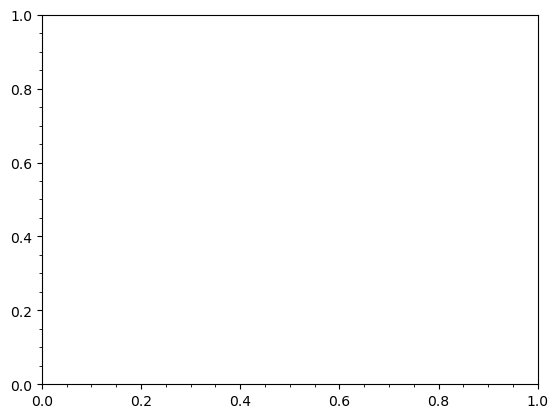

In [56]:
catchment_list = meuse_names_fr_total
yrsl = yrsl_fr
yrcut = yrcut_fr
SRmax_FR = pd.DataFrame()
for i in range(len(catchment_list)):  
    name = fr_dict_code[stations_total[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations_total[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')

    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']

    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()

    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    

    data = data.loc["1989-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1989-01-01":"2018-12-31","Q_mm_area"]

    data['year'] = pd.DatetimeIndex(data['dt']).year
    
    # budyko plot
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
    plt.minorticks_on()
        
    fig, axs = plt.subplots(1, 1)
    fig.set_figheight(4)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')
        
    axs.plot(energy_limit_x, energy_limit_y, c='k')
    axs.plot(budyko_curve_x, water_limit_y,c='k')
    axs.set_ylabel("Actual ET/P")
    axs.set_xlabel("Potential ET/P")
    axs.minorticks_on()
        
    data['year'] = pd.DatetimeIndex(data['dt']).year  
    
    
    
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        data_past_decades = data.loc[(yrcut[0] <= data['year']) & (data['year'] < yrcut[j+1])]
        c = colors[j]
        yearslice = yrsl[j]    
                    
        #Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()

        #Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        if AI < EI:
            print(f'Exclude catchment with ID {catchment_list[i]}')
                    
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)


        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        axs.plot(AI, EI, marker='o', color=c, label=f'Decade {yrsl[j]}',markersize =10)
        plt.legend()
    
    plt.savefig(f'2_Output/{output}/Budyko/{catchment_list[i]}.png')   
    plt.close(fig)
    


catchment_list = meuse_names_be_total
yrsl = yrsl_be
yrcut = yrcut_be
SRmax_BE = pd.DataFrame()
df_output = df_output_be


for i in range(len(catchment_list)):
    if catchment_list[i] == "Salzines Ronet ":
        catchment_list[i] = "Salzinnes"
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']

    name = catchment_list[i].strip()
    nameupper = name.upper()

    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']

    if name == "Salzinnes":
        name = "Salzinnes Ronet"
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()
    
    if catchment_list[i] !=  "Maastricht":
        dataq["hour"] = dataq["Q"] * 3600
        dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    else:
        dataq_day = dataq
        dataq['Q_mm'] = dataq_day['Q'] * 10**3 * 3600 * 24
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    # print(catchment_list[i])
    # print("dataq time range:", dataq["dt"].dt.date.min(), "to", dataq["dt"].dt.date.max())
    # print("data time range:", data["dt"].dt.date.min(), "to", data["dt"].dt.date.max())

    data = data.loc["1999-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1999-01-01":"2018-12-31","Q_mm_area"]

    data['year'] = pd.DatetimeIndex(data['dt']).year
    
    # budyko plot
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
    plt.minorticks_on()
        
    fig, axs = plt.subplots(1, 1)
    fig.set_figheight(4)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')
        
    axs.plot(energy_limit_x, energy_limit_y, c='k')
    axs.plot(budyko_curve_x, water_limit_y,c='k')
    axs.set_ylabel("Actual ET/P")
    axs.set_xlabel("Potential ET/P")
    axs.minorticks_on()
    
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        data_past_decades = data.loc[(yrcut[0] <= data['year']) & (data['year'] < yrcut[j+1])]
        c = colors[j]
        yearslice = yrsl[j]    
                    
        #Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()

        #Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        if AI < EI:
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
                    
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)

        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        axs.plot(AI, EI, marker='o', color=c, label=f'omega = {w:.5f}',markersize =10)

    
    plt.savefig(f'2_Output/{output}/Budyko/{catchment_list[i]}.png')   
    plt.close(fig)

## EI deviations

In [22]:
yrsl = yrsl_fr

for j in range(len(yrsl)):
    if j > 1:
        for i in range(len(df_output_fr)):
            catch_dat = df_output_fr.iloc[i]
            idx = df_output_fr.index[i]
            wflow = WFLOW[idx]
            EI_dev = catch_dat[f'EI deviation {yrsl[j]}']
                
            print(wflow, "{:.2f}".format(EI_dev))

                
yrsl = yrsl_be

for j in range(len(yrsl)):
    if j > 0:
        for i in range(len(df_output_be)):
            catch_dat = df_output_be.iloc[i]
            idx = df_output_be.index[i]
            wflow = WFLOW[idx]
            EI_dev = catch_dat[f'EI deviation {yrsl[j]}']
                
            print(wflow, "{:.2f}".format(EI_dev))

                
               

1011 0.02
1013 -0.05
1016 -0.05
101 -0.01
3 -0.03
203 -0.21
209 -0.18
201 -0.18
41 -0.10
42 -0.06
5 -0.15
501 -0.15
6 -0.04
4 -0.10
802 -0.12
803 -0.17
701 -0.03
703 -0.04
1002 -0.14
903 -0.01
9 -0.05
13 -0.05
1401 -0.11


# Make files with Sr values

In [23]:
print(meuse_names_be_total)

['Membre Pont ', 'Sainte-Marie', 'Straimont ', 'Treignes ', 'Chooz ', 'Daverdisse ', 'Jemelle ', 'Gendron ', 'Hastiere', 'Yvoir ', 'Warnant ', 'Modave ', 'Ortho ', 'Mabompre ', 'Tabreux ', 'Wiheries ', 'Salzinnes ', 'Huccorgne ', 'Amay ', 'Martinrive ', 'Chaudfontaine Pisc ', 'Maastricht']


In [24]:
EI_dev_total = EI_dev_FR + EI_dev_BE
print(EI_dev_total)

[-0.01878173667803751, 0.011551250985167738, 3.57358468209279e-05, -0.053021286642643495, -0.016344718253714086, -0.05697579334768521, 0.02254211717947452, 0.0026621416864553993, 0.00209345465935451, -0.03277699100980369, -0.0061819635288618, -0.2009426685757864, 0.004224760572106301, -0.1794197364118656, -0.007741950141103016, -0.1840965515667835, 0.001963634868214603, -0.09834383370319866, 0.0040794698271158225, -0.05409013762049797, -0.14976892838565992, -0.14765447523554498, -0.0444218526675787, -0.09778086849750578, -0.12458782468931623, -0.1709000427476539, -0.03363627193381158, -0.035056668005021496, -0.1398667416036038, -0.007932157273164875, -0.04766552213802433, -0.053203745769737854, -0.10953870936475008]


In [25]:
# import random

# random_sample_EI = random.sample(EI_dev_total, k=1) 

# print(random_sample_EI)

[-0.053021286642643495]


In [53]:
# print(meuse_names_fr_total)
# print(meuse_names_be_total)

# print(len(meuse_names_fr_total)+ len(meuse_names_be_total))

#### Calculate base case Srmax (Both datasets)

In [51]:
catchment_list = meuse_names_fr_total
yrsl = yrsl_be
yrcut = yrcut_be
SRmax_FR = pd.DataFrame()

for i in range(len(catchment_list)):  
    name = fr_dict_code[stations_total[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations_total[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')

    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']

    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()

    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area

    data = data.loc["1999-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1989-01-01":"2018-12-31","Q_mm_area"]

    data['year'] = pd.DatetimeIndex(data['dt']).year        

    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]     
        
        # Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()

        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
    
        # Calculate root zone storage deficits
        P_ts  = datanew['prec_subcatch']
        EP_ts = datanew['epot_subcatch']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD
        
        
        datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
        df_out = pd.DataFrame(index = datanew.index)
        df_out['hydroyear'] = datanew['year']
        df_out['SD_sum'] = datanew['SD']
        
        Sr_2 = rootzone(df_out,2)[0]
        Sr_20 = rootzone(df_out,20)[0]
        
        SRmax_FR.loc[catchment_list[i],[f'Sr_2 {yrsl[j]}']] = Sr_2
        SRmax_FR.loc[catchment_list[i],[f'Sr_20 {yrsl[j]}']] = Sr_20
    

catchment_list = meuse_names_be_total
SRmax_BE = pd.DataFrame()
df_output = df_output_be

for i in range(len(catchment_list)):
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']

    name = catchment_list[i].strip()
    nameupper = name.upper()

    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']

    if name == "Salzinnes":
        name = "Salzinnes Ronet"
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()
    
    if catchment_list[i] !=  "Maastricht":
        dataq["hour"] = dataq["Q"] * 3600
        dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    else:
        dataq_day = dataq
        dataq['Q_mm'] = dataq_day['Q'] * 10**3 * 3600 * 24
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area

    data = data.loc["1999-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1999-01-01":"2018-12-31","Q_mm_area"]

    data['year'] = pd.DatetimeIndex(data['dt']).year
    
    
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        
        # Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()
        
        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
    
        # Calculate root zone storage deficits
        P_ts  = datanew['prec_subcatch']
        EP_ts = datanew['epot_subcatch']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD
        
        datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
        df_out = pd.DataFrame(index = datanew.index)
        df_out['hydroyear'] = datanew['year']
        df_out['SD_sum'] = datanew['SD']
        
        Sr_2 = rootzone(df_out,2)[0]
        Sr_20 = rootzone(df_out,20)[0]
        
        SRmax_BE.loc[catchment_list[i],[f'Sr_2 {yrsl[j]}']] = Sr_2
        SRmax_BE.loc[catchment_list[i],[f'Sr_20 {yrsl[j]}']] = Sr_20
        
SRmax_base = pd.concat([SRmax_BE, SRmax_FR])
display(SRmax_base)


,Sr_2 1999 - 2008,Sr_20 1999 - 2008,Sr_2 2009 - 2018,Sr_20 2009 - 2018
Membre Pont,113.761593,175.123006,83.795223,150.923850
Sainte-Marie,154.368907,227.503526,110.466426,188.276787
Straimont,109.422217,172.451871,78.602806,146.420934
Treignes,109.220086,174.837387,112.834062,193.271077
Chooz,108.711458,175.322962,93.870878,163.117401
Daverdisse,116.720347,184.356898,100.143020,167.138666
Jemelle,107.370039,180.852501,71.836416,136.253987
Gendron,126.601861,207.154879,106.552108,182.541863
Hastiere,100.454330,166.438578,111.941146,183.081008
Yvoir,133.018788,224.460869,123.621074,210.288629


In [52]:
SRmax_base_WFLOW_first = pd.DataFrame(columns = ['WFLOW', 'Sr_2', 'Sr_20'])
SRmax_base_WFLOW_second = pd.DataFrame(columns = ['WFLOW', 'Sr_2', 'Sr_20'])
yrsl = yrsl_be

for i in range(len(SRmax_base)):
    name = SRmax_base.index[i]
    wflow = WFLOW[name]
    subcatch = SRmax_base.iloc[i]
    Sr_2_first = subcatch[f'Sr_2 {yrsl[0]}']
    Sr_20_first = subcatch[f'Sr_20 {yrsl[0]}']
    Sr_2_second = subcatch[f'Sr_2 {yrsl[1]}']
    Sr_20_second = subcatch[f'Sr_20 {yrsl[1]}']
    
    SRmax_base_WFLOW_first.loc[i, 'WFLOW'] = wflow
    SRmax_base_WFLOW_second.loc[i, 'WFLOW'] = wflow
    
    SRmax_base_WFLOW_first.loc[i, 'Sr_2'] = Sr_2_first
    SRmax_base_WFLOW_first.loc[i, 'Sr_20'] = Sr_20_first

    SRmax_base_WFLOW_second.loc[i, 'Sr_2'] = Sr_2_second
    SRmax_base_WFLOW_second.loc[i, 'Sr_20'] = Sr_20_second
    
#     SRmax_base_WFLOW.loc[i, 'WFLOW'] = wflow
#     SRmax_base_WFLOW.loc[i, 'Sr_2'] = Sr_2
#     SRmax_base_WFLOW.loc[i, 'Sr_20'] = Sr_20
    
#     Sr_2 = round(Sr_2, 2)
#     Sr_20 = round(Sr_20, 2)

#     print(wflow, Sr_2, Sr_20)


SRmax_base_WFLOW_first.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/9_TOML/1_Input/SRfirst/SRmax_base.csv', index=False)
SRmax_base_WFLOW_second.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/9_TOML/1_Input/SRsecond/SRmax_base.csv', index=False)

#### Calculate expected Srmax - with sample (Both datasets)

In [55]:
"FR - calculate expected Sr"
catchment_list = meuse_names_fr_total
warnings.filterwarnings('ignore')
yrsl = yrsl_be
yrcut = yrcut_be
df_output = df_output_fr

for i in range(len(catchment_list)):
    name = fr_dict_code[stations[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1989-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1989-01-01":"2018-12-31","Q_mm_area"]

    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        if j > 0:
            datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
                    
            #Compute the Makkink potential evaporation
            Ep = datanew['epot_subcatch'].mean()    
            T = datanew['temp_subcatch'].mean()
            P  = datanew['prec_subcatch'].mean()
            Q  = datanew['dis_subcatch'].mean()

            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            Ea_exp = EI_exp * P
        
            # Calculate root zone storage deficits
            RP    = 20 #Return-period of 20 years
            P_ts  = datanew['prec_subcatch']
            EP_ts = datanew['epot_subcatch']

            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z]/Ep) * Ea_exp
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD
        
            datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr = rootzone(df_out,RP)[0]
            
            print(Sr)
 

warnings.filterwarnings('ignore')
catchment_list = meuse_names_be2
yrsl = yrsl_be
yrcut = yrcut_be
df_output = df_output_be

for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    if name == "Salzinnes":
        name = "Salzinnes Ronet"
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()
    
    if catchment_list[i] !=  "Maastricht":
        dataq["hour"] = dataq["Q"] * 3600
        dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    else:
        dataq_day = dataq
        dataq['Q_mm'] = dataq_day['Q'] * 10**3 * 3600 * 24
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    
    # get the right dates (1996 - 2016)
    data = data.loc["1999-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1999-01-01":"2018-12-31","Q_mm_area"]
            
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        if j > 0:
            datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        
            # Compute the Makkink potential evaporation
            Ep = datanew['epot_subcatch'].mean()    
            T = datanew['temp_subcatch'].mean()
            P  = datanew['prec_subcatch'].mean()
            
            EI_exp = df_output.loc[catchment_list[i],[f'EI expected {yrsl[j]}']].item()
            Ea_exp = EI_exp * P
        
            # Calculate root zone storage deficits
            RP    = 20 #Return-period of 20 years
            P_ts  = datanew['prec_subcatch']
            EP_ts = datanew['epot_subcatch']

            Et = np.zeros(len(P_ts))
            SD = np.zeros(len(P_ts))

            for z in range(len(P_ts)):
                Et[z] = (EP_ts[z]/Ep) * Ea_exp
                if z == 0:
                    SD[z] = min(0, P_ts[z] - Et[z])
                else:
                    SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
            datanew.loc[:,'SD'] = SD


            datanew['year'] = pd.DatetimeIndex(datanew['dt']).year
            df_out = pd.DataFrame(index = datanew.index)
            df_out['hydroyear'] = datanew['year']
            df_out['SD_sum'] = datanew['SD']
            Sr = rootzone(df_out,RP)[0]   

216.588956931797
226.7539801373241
202.21779131383522
189.2450653475116
182.97612962462205
298.41602927903216


KeyError: 'La Crusnes Pierrepont'

In [30]:
for s in range(50):
    catchment_list = meuse_names_fr_total
    yrsl = yrsl_fr
    yrcut = yrcut_fr
    SRmax_FR = pd.DataFrame()
    for i in range(len(catchment_list)):  
        name = fr_dict_code[stations_total[i]]
        df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations_total[i]]
        df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
        df_station.index = df_station['dt']
        df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
        dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
        dataq_fr = dataq_fr.dropna(axis='rows')

        data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
        data.loc[:,'dt'] = pd.to_datetime(data['dt'])
        data.index = data['dt']

        namefr = fr_dict_inv[name]  
        are = df_area[df_area['Station']== namefr]
        area = are['area_m2'].item()

        dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
        dataq_fr_day = dataq_fr.resample('D').sum() 
        dataq_fr_day["day"] = dataq_fr_day["hour"]
        dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
        dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area

        data = data.loc["1989-01-01":"2018-12-31"]
        data['dis_subcatch'] = dataq_fr_day.loc["1989-01-01":"2018-12-31","Q_mm_area"]

        data['year'] = pd.DatetimeIndex(data['dt']).year

        #Compute the Makkink potential evaporation
        Ep = data['epot_subcatch'].mean()    
        T = data['temp_subcatch'].mean()
        P  = data['prec_subcatch'].mean()
        Q  = data['dis_subcatch'].mean()

        #     #Compute actual evaporation, Evaporative Index and Aridity index
        Ea = P - Q 
        EI = Ea / P
        AI = Ep / P

        EI_sample = EI + random.sample(EI_dev_total, k=1)[0]

        Ea_sample = EI_sample * P

        P_ts  = data['prec_subcatch']
        EP_ts = data['epot_subcatch']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea_sample
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        data.loc[:,'SD'] = SD


        data['year'] = pd.DatetimeIndex(data['dt']).year
        df_out = pd.DataFrame(index = data.index)
        df_out['hydroyear'] = data['year']
        df_out['SD_sum'] = data['SD']
        Sr_2 = rootzone(df_out,2)[0]
        Sr_20 = rootzone(df_out,20)[0]

        SRmax_FR.loc[catchment_list[i],[f'Sr_2']] = Sr_2
        SRmax_FR.loc[catchment_list[i],[f'Sr_20']] = Sr_20

    catchment_list = meuse_names_be_total
    yrsl = yrsl_be
    yrcut = yrcut_be
    SRmax_BE = pd.DataFrame()
    df_output = df_output_be

    for i in range(len(catchment_list)):
        data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
        data.loc[:,'dt'] = pd.to_datetime(data['dt'])
        data.index = data['dt']

        name = catchment_list[i].strip()
        nameupper = name.upper()

        dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
        dataq.columns = ['dt', 'Q']
        dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
        dataq.index = dataq['dt']

        if name == "Salzinnes":
            name = "Salzinnes Ronet"
        are = df_area[df_area['Station']== name]
        area = are['area_m2'].item()

        dataq["hour"] = dataq["Q"] * 3600
        dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area

        data = data.loc["1999-01-01":"2018-12-31"]
        data['dis_subcatch'] = dataq_day.loc["1999-01-01":"2018-12-31","Q_mm_area"]

        data['year'] = pd.DatetimeIndex(data['dt']).year

        # Compute the Makkink potential evaporation
        Ep = data['epot_subcatch'].mean()    
        T = data['temp_subcatch'].mean()
        P  = data['prec_subcatch'].mean()

        EI_sample = EI + random.sample(EI_dev_total, k=1)[0]
        Ea_sample = EI_sample * P

        # Calculate root zone storage deficits
        P_ts  = data['prec_subcatch']
        EP_ts = data['epot_subcatch']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea_sample
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        data.loc[:,'SD'] = SD

        data['year'] = pd.DatetimeIndex(data['dt']).year
        df_out = pd.DataFrame(index = data.index)
        df_out['hydroyear'] = data['year']
        df_out['SD_sum'] = data['SD']
        Sr_2 = rootzone(df_out,2)[0]
        Sr_20 = rootzone(df_out,20)[0]

        SRmax_BE.loc[catchment_list[i],[f'Sr_2']] = Sr_2
        SRmax_BE.loc[catchment_list[i],[f'Sr_20']] = Sr_20   
            
    SRmax = pd.concat([SRmax_BE, SRmax_FR])
    SRmax_WFLOW = pd.DataFrame(columns = ['WFLOW', 'Sr_2', 'Sr_20'])
    for i in range(len(SRmax)):
        name = SRmax.index[i]
        wflow = WFLOW[name]
        subcatch = SRmax.iloc[i]
        Sr_2 = subcatch['Sr_2']
        Sr_20 = subcatch['Sr_20']
        SRmax_WFLOW.loc[i, 'WFLOW'] = wflow
        SRmax_WFLOW.loc[i, 'Sr_2'] = Sr_2
        SRmax_WFLOW.loc[i, 'Sr_20'] = Sr_20
    

    # display(SRmax_WFLOW)
    # SRmax_WFLOW.to_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/9_TOML/1_Input/SRpandas/SRmax_{s+1}.csv', index=False)

KeyboardInterrupt: 

# Plot results (Archive)

## Histogram EI deviations (grouped)

### Histogram EI deviations combined time periods (not overlapping)

In [ ]:
# "Histogram EI deviations combined time periods (not overlapping)"

"Histogram EI deviations combined time periods (not overlapping) - ONE DECADE"

colors3 = [colors[0], colors[1], "#95bb72"]
labels = [f'France {yrsl_fr[1]}', f'France {yrsl_fr[2]}', f'Belgium {yrsl_be[0]}']

fig = plt.figure()
fig.set_figheight(4.5)
fig.set_figwidth(3.5)
EI_dev_grouped = [[], [], []]
w = ['', '', '']

df_output = df_output_fr
catchment_list = meuse_names_fr
        
for j in range(len(yrsl_fr)):  
    EI_dev_total = []
    if j > 0:
        for i in range(len(catchment_list)):
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl_fr[j]}']].item()
            EI_dev_grouped[j-1].append(EI_dev)
                
df_output = df_output_be
catchment_list = meuse_names_be2 
                
for j in range(len(yrsl_be)):  
    EI_dev_total = []
    if j > 0:
        for i in range(len(catchment_list)):
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl_be[j]}']].item()
            EI_dev_grouped[2].append(EI_dev)
            
for a in range(len(EI_dev_grouped)):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)
            
            
ax = plt.axes()
ax.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
plt.hist(EI_dev_grouped, bins=7, alpha = 0.75, color = colors3, label=labels, orientation='horizontal',weights=w)
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Nr of catchments')
plt.legend(loc='lower right')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))


ax2 = plt.gca().twiny()

for i in range(len(EI_dev_grouped)):
    sns.histplot(data=EI_dev_grouped[i], element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, color=colors3[i], y = EI_dev_grouped[i], linewidth = 2, linestyle='solid')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax2.grid('false')
ax2.set_xlabel('Cumulative')

# print(EI_dev_grouped)
ax2.grid(False)
ax2.set_facecolor("None")

plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_4.png')   

In [ ]:
# "Histogram EI deviations combined time periods (not overlapping)"

"Histogram EI deviations combined time periods (not overlapping) - PAST DECADEs"

colors3 = [colors[0], colors[1], "#95bb72"]
labels = [f'France {yrsl_fr[1]}', f'France {yrsl_fr[2]}', f'Belgium {yrsl_be[0]}']

fig = plt.figure()
fig.set_figheight(4.5)
fig.set_figwidth(3.5)
EI_dev_grouped = [[], [], []]
w = ['', '', '']


df_output = df_output_fr
catchment_list = meuse_names_fr
        
for j in range(len(yrsl_fr)):  
    EI_dev_total = []
    if j > 0:
        for i in range(len(catchment_list)):
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation past decades {yrsl_fr[j]}']].item()
            EI_dev_grouped[j-1].append(EI_dev)
                
df_output = df_output_be
catchment_list = meuse_names_be2 
                
for j in range(len(yrsl_be)):  
    EI_dev_total = []
    if j > 0:
        for i in range(len(catchment_list)):
            EI_dev = df_output.loc[catchment_list[i],[f'EI deviation past decades {yrsl_be[j]}']].item()
            EI_dev_grouped[2].append(EI_dev)
            
for a in range(len(EI_dev_grouped)):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)
            
            
ax = plt.axes()
ax.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
plt.hist(EI_dev_grouped, bins=7, alpha = 0.75, color = colors3, label=labels, orientation='horizontal',weights=w)
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Nr of catchments')
plt.legend(loc='lower right')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

ax2 = plt.gca().twiny()

for i in range(len(EI_dev_grouped)):
    sns.histplot(data=EI_dev_grouped[i], element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, color=colors3[i], y = EI_dev_grouped[i], linewidth = 2, linestyle='solid')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax2.grid('false')
ax2.set_xlabel('Cumulative')
# print(EI_dev_grouped)
ax2.grid(False)
ax2.set_facecolor("None")

plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_4.png')   

### Histogram EI deviations grouped by aridity (not overlapping) (FR+BE)

In [ ]:
"Histogram EI deviations grouped by AI (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = [[], [], []]
w = ["", "", ""]
labels = [f"AI < 0.33", f"0.33 < AI < 0.66", f"0.66 < AI"]

print(len(catchment_list_AI_fr[0]), len(catchment_list_AI_be[0]))
print(len(catchment_list_AI_fr[1]), len(catchment_list_AI_be[1]))
print(len(catchment_list_AI_fr[2]), len(catchment_list_AI_be[2]))


for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_AI = catchment_list_AI_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_AI = catchment_list_AI_be   
        
    
    for a in range(len(catchment_list_AI)):
        EI_dev_total = []
        catchment_list = catchment_list_AI[a]
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
             

for a in range(len(catchment_list_AI)):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)

print(catchment_list_AI_fr)
print(EI_dev_grouped)


# Label maken

des = 'AI'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_AI} (n={n1})", f"{cut1_AI} < {des} < {cut2_AI} (n={n2})", f"{des} > {cut2_AI} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[1:3]
w = w[1:3]
labels = labels[1:3]
c = colors2[1:3]
        
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)




# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_Aridity.png')   

### Histogram EI deviations grouped by Seasonality Index (not overlapping) (FR+BE)

In [ ]:
"Histogram EI deviations grouped by P (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = [[], [], []]
w = ["", "", ""]
labels = [f"SI < {cut1_SI}",
          f"{cut1_SI} <= SI < {cut2_SI}",
          f"{cut2_SI} <= SI"]

print(len(catchment_list_SI_fr[0]), len(catchment_list_SI_be[0]))
print(len(catchment_list_SI_fr[1]), len(catchment_list_SI_be[1]))
print(len(catchment_list_SI_fr[2]), len(catchment_list_SI_be[2]))


for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_SI = catchment_list_SI_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_SI = catchment_list_SI_be   
        
    
    for a in range(len(catchment_list_SI)):
        EI_dev_total = []
        catchment_list = catchment_list_SI[a]
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
             
for a in range(len(catchment_list_SI)):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)

# Label maken

des = 'SI'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_SI} (n={n1})", f"{cut1_SI} < {des} < {cut2_SI} (n={n2})", f"{des} > {cut2_SI} (n={n3})"]        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:2]
w = w[0:2]
labels = labels[0:2]
c = colors2[0:2]
        
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)



# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_SI.png')   

### Histogram EI deviations grouped by Seasonality Timing (not overlapping) (FR+BE)

In [ ]:
"Histogram EI deviations grouped by ST (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = [[], [], []]
w = ["", "", "", "", "", "", ""]
labels = [f"ST < {cut1_ST}",
          f"{cut1_ST} <= ST < {cut2_ST}",
          f"{cut2_ST} <= ST"]


print(len(catchment_list_ST_fr[0]), len(catchment_list_ST_be[0]))
print(len(catchment_list_ST_fr[1]), len(catchment_list_ST_be[1]))
print(len(catchment_list_ST_fr[2]), len(catchment_list_ST_be[2]))

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_ST = catchment_list_ST_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_ST = catchment_list_ST_be   
        
    
    for a in range(len(catchment_list_ST)):
        EI_dev_total = []
        catchment_list = catchment_list_ST[a]
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
             
for a in range(3):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)

# Label maken

des = 'ST'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_ST} (n={n1})", f"{cut1_ST} < {des} < {cut2_ST} (n={n2})", f"{des} > {cut2_ST} (n={n3})"]               

# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[1:3]
w = w[1:3]
labels = labels[1:2]
c = colors2[1:3]
        
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_Seasonality_4.png')   

### Histogram EI deviations grouped by Interstorm duration (not overlapping)

In [ ]:
"Histogram EI deviations grouped by interstorm duration (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = [[], [], []]
w = ["", "", ""]
labels = [f"Is_dur < {cut1_isdur}",
          f"{cut1_isdur} <= Is_dur < {cut2_isdur}",
          f"{cut2_isdur} <= Is_dur"]

print(len(catchment_list_isdur_be[0]))
print(len(catchment_list_isdur_be[1]))
print(len(catchment_list_isdur_be[2]))

print(len(catchment_list_isdur_fr[0]))
print(len(catchment_list_isdur_fr[1]))
print(len(catchment_list_isdur_fr[2]))


for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_isdur = catchment_list_isdur_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_isdur = catchment_list_isdur_be   
        
    
    for a in range(len(catchment_list_isdur)):
        EI_dev_total = []
        catchment_list = catchment_list_isdur[a]
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
             
for a in range(3):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)

# Label maken

des = 'is_dur'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_isdur} (n={n1})", f"{cut1_isdur} < {des} < {cut2_isdur} (n={n2})", f"{des} > {cut2_isdur} (n={n3})"]                  

# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:2]
w = w[0:2]
labels = labels[0:2]
c = colors2[0:2]
        
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation= 'horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_isdur_4.png')   

### Histogram EI deviations grouped by mean annual values (not overlapping) (FR+BE)

In [ ]:
"Histogram EI deviations grouped by P (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = [[], [], []]
w = ["", "", ""]
labels = [f"P < {cut1_Pa}",
          f"{cut1_Pa} <= P < {cut2_Pa}",
          f"{cut2_Pa} <= P"]


for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_Pa = catchment_list_Pa_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_Pa = catchment_list_Pa_be   
        
    
    for a in range(len(catchment_list_Pa)):
        EI_dev_total = []
        catchment_list = catchment_list_Pa[a]
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
             
for a in range(len(catchment_list_Pa)):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)

# Label maken

des = 'P'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_Pa} (n={n1})", f"{cut1_Pa} < {des} < {cut2_Pa} (n={n2})", f"{des} > {cut2_Pa} (n={n3})"]               

# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[1:2]
w = w[1:2]
labels = labels[1:2]
c = colors2[1:2]
        
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation="horizontal")
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


print(len(catchment_list_Pa_be[0]))
print(len(catchment_list_Pa_be[1]))
print(len(catchment_list_Pa_be[2]))

print(len(catchment_list_Pa_fr[0]))
print(len(catchment_list_Pa_fr[1]))
print(len(catchment_list_Pa_fr[2]))


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_Pa.png')   

In [ ]:
"Histogram EI deviations grouped by Pe (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = [[], [], []]
w = ["", "", ""]
labels = [f"Ep < {cut1_Epa}",
          f"{cut1_Epa} <= Ep < {cut2_Epa}",
          f"{cut2_Epa} <= Ep"]

           
for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_Epa = catchment_list_Epa_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_Epa = catchment_list_Epa_be   
        
    
    for a in range(len(catchment_list_Epa)):
        EI_dev_total = []
        catchment_list = catchment_list_Epa[a]
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
             
for a in range(len(catchment_list_Epa)):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)

# Label maken

des = 'Ep'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_Epa} (n={n1})", f"{cut1_Epa} < {des} < {cut2_Epa} (n={n2})", f"{des} > {cut2_Epa} (n={n3})"]            

# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[1:2]
w = w[1:2]
labels = labels[1:2]
c = colors2[1:2]
        
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation="horizontal")
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)

print(len(catchment_list_Epa_be[0]))
print(len(catchment_list_Epa_be[1]))
print(len(catchment_list_Epa_be[2]))

print(len(catchment_list_Epa_fr[0]))
print(len(catchment_list_Epa_fr[1]))
print(len(catchment_list_Epa_fr[2]))


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_Seasonality_4.png')   

In [ ]:
"Histogram EI deviations grouped by T (not overlapping)"

# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
EI_dev_grouped = [[], [], []]
w = ["", "", ""]
labels = [f"T < {cut1_T}",
          f"{cut1_T} <= T < {cut2_T}",
          f"{cut2_T} <= T"]
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_T = catchment_list_T_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_T = catchment_list_T_be   
        
    
    for a in range(len(catchment_list_T)):
        EI_dev_total = []
        catchment_list = catchment_list_T[a]
    
        for j in range(len(yrsl)):  
            if j > 0:
                for i in range(len(catchment_list)):
                    EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                    EI_dev_grouped[a].append(EI_dev)
             
for a in range(len(catchment_list_T)):
    if EI_dev_total != 0:
        w[a] = np.ones_like(EI_dev_grouped[a])/(len(EI_dev_grouped[a]))
    else:
        w[a] = np.array(0)
# Label maken

des = 'T'                

n1 = len(EI_dev_grouped[0]) 
n2 = len(EI_dev_grouped[1])
n3 = len(EI_dev_grouped[2])

print(n1, n2, n3)
                
labels = [f"{des} < {cut1_T} (n={n1})", f"{cut1_T} < {des} < {cut2_T} (n={n2})", f"{des} > {cut2_T} (n={n3})"]            
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev_grouped = EI_dev_grouped[0:2]
w = w[0:2]
labels = labels[0:2]
c = colors2[0:2]
        
plt.hist(EI_dev_grouped, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation="horizontal")
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)


# plt.legend(loc='lower right')
plt.savefig(f'2_Output/{output}/Histograms/Histogram_time_combined_notoverlapping_Seasonality_4.png')   

print(len(catchment_list_T_be[0]))
print(len(catchment_list_T_be[1]))
print(len(catchment_list_T_be[2]))

print(len(catchment_list_T_fr[0]))
print(len(catchment_list_T_fr[1]))
print(len(catchment_list_T_fr[2]))

## Change vs change

### Aridity

In [ ]:
" Change vs change: aridity"


# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
w = ["", "", ""]
    
change1 = -0.05
change2 = 0.05
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des = 'AI'
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list_change = meuse_names_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list_change = meuse_names_be2   
        
    
    EI_dev_total = []
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list_change)):
                des_change = df_output.loc[catchment_list_change[i],[f'{des}_change {yrsl[j]}']].item()
                EI_dev = df_output.loc[catchment_list_change[i],[f'EI deviation {yrsl[j]}']].item()
                if des_change < change1:
                    des_change1.append(des_change)
                    EI_dev1.append(EI_dev)    
                elif change1 <= des_change and des_change < change2:
                    des_change2.append(des_change)
                    EI_dev2.append(EI_dev)
                elif change2 <= des_change:
                    des_change3.append(des_change)
                    EI_dev3.append(EI_dev)
                        

EI_dev = EI_dev1, EI_dev2, EI_dev3

print(EI_dev)
n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

             
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)

labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[1:3]
w = w[1:3]
labels = labels[1:3]
c = colors4[1:3]  

        
# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            



# plt.legend(loc='lower right')
                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   


### Precipitation

15 9 1


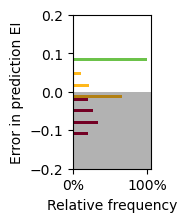

In [32]:
" Change vs change: annual precipitation"


# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
w = ["", "", ""]
    
change1 = -20
change2 = 20
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des='Pa'
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list = meuse_names_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list = meuse_names_be2 
        
    
    EI_dev_total = []
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'Pa_change {yrsl[j]}']].item()
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                if des_change < change1:
                    des_change1.append(des_change)
                    EI_dev1.append(EI_dev)    
                elif change1 <= des_change and des_change < change2:
                    des_change2.append(des_change)
                    EI_dev2.append(EI_dev)
                elif change2 <= des_change:
                    des_change3.append(des_change)
                    EI_dev3.append(EI_dev)
                        
EI_dev = EI_dev1, EI_dev2, EI_dev3
n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

             
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)

labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  

        
# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            

    


# plt.legend(loc='lower right')
                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   


### Evaporation

0 2 23
5.713094231835498
29.160758204758167


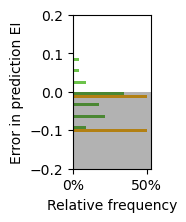

In [33]:
" Change vs change: annual evaporation"


# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
w = ["", "", ""]
    
change1 = -10
change2 = 10
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des='Epa'
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list = meuse_names_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list = meuse_names_be2   
        
    
    EI_dev_total = []
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                des_change_total.append(des_change)
                if des_change < change1:
                    des_change1.append(des_change)
                    EI_dev1.append(EI_dev)    
                elif change1 <= des_change and des_change < change2:
                    des_change2.append(des_change)
                    EI_dev2.append(EI_dev)
                elif change2 <= des_change:
                    des_change3.append(des_change)
                    EI_dev3.append(EI_dev)
                        
EI_dev = EI_dev1, EI_dev2, EI_dev3
n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
             
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)

labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  

        
# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            

    


# plt.legend(loc='lower right')
                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   


0 5 20
-0.08909641345080388
0.586198184404493


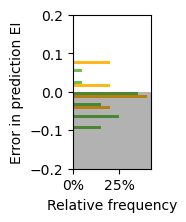

In [34]:
" Change vs change: Temperature"


# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
w = ["", "", ""]
    
change1 = -0.2
change2 = 0.2
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des='T'
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list = meuse_names_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list = meuse_names_be2
        
    
    EI_dev_total = []
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                des_change_total.append(des_change)
                if des_change < change1:
                    des_change1.append(des_change)
                    EI_dev1.append(EI_dev)    
                elif change1 <= des_change and des_change < change2:
                    des_change2.append(des_change)
                    EI_dev2.append(EI_dev)
                elif change2 <= des_change:
                    des_change3.append(des_change)
                    EI_dev3.append(EI_dev)
                        
EI_dev = EI_dev1, EI_dev2, EI_dev3
n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
             
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)

labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  

        
# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            

    


# plt.legend(loc='lower right')
                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   


### Interstorm duration

11 11 3
-0.4450278510061949
0.3275106261075802


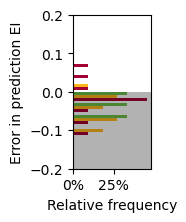

In [35]:
" Change vs change: interstorm duration"


# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
w = ["", "", ""]
    
change1 = -0.1
change2 = 0.1
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des='is_dur'
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list = meuse_names_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list = meuse_names_be2   
        
    
    EI_dev_total = []
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                des_change_total.append(des_change)
                if des_change < change1:
                    des_change1.append(des_change)
                    EI_dev1.append(EI_dev)    
                elif change1 <= des_change and des_change < change2:
                    des_change2.append(des_change)
                    EI_dev2.append(EI_dev)
                elif change2 <= des_change:
                    des_change3.append(des_change)
                    EI_dev3.append(EI_dev)
                        
EI_dev = EI_dev1, EI_dev2, EI_dev3
n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)

print(min(des_change_total))
print(max(des_change_total))
             
for a in range(3):
    if EI_dev[a] != 0:
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)

labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  

        
# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            

    


# plt.legend(loc='lower right')
                
plt.savefig(f'2_Output/{output}/Results/AI_change.png')   


### Seasonality index

0 13 10


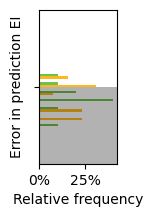

In [36]:
" Change vs change: Seasonality index"


# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
w = ["", "", ""]
    
change1 = -0.02
change2 = 0.02
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des='SI'
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list = meuse_names_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list = meuse_names_be2   
        
    
    EI_dev_total = []
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                des_change_total.append(des_change)
                if des_change < change1:
                    des_change1.append(des_change)
                    EI_dev1.append(EI_dev)    
                elif change1 <= des_change and des_change < change2:
                    des_change2.append(des_change)
                    EI_dev2.append(EI_dev)
                elif change2 <= des_change:
                    des_change3.append(des_change)
                    EI_dev3.append(EI_dev)
                        
                        
EI_dev1 = ''
                        
EI_dev = EI_dev1, EI_dev2, EI_dev3
n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)


             
for a in range(3):
    if EI_dev[a] != 0 and EI_dev[a] != '':
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)

labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  

        
# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            

    


# plt.legend(loc='lower right')
                
plt.savefig(f'2_Output/{output}/Results/SI_change.png')   


### Seasonality Timing

0 12 12


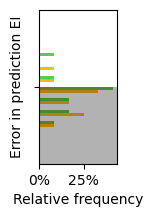

In [37]:
" Change vs change: Seasonality Timing"


# Hetzelfde bij elke

fig = plt.figure()
# fig.set_figheight(9)
# fig.set_figwidth(3.5)
fig.set_figheight(2)
fig.set_figwidth(1)
w = ["", "", ""]
    
change1 = -0.02
change2 = 0.02
    
des_change1 = []
des_change2 = []
des_change3 = []

des_change_total = []

EI_dev1 = []
EI_dev2 = []
EI_dev3 = []

des='ST'
  

for c in range(2):
    if c == 0:
        df_output = df_output_fr
        yrsl = yrsl_fr
        catchment_list = meuse_names_fr
        
    if c == 1:
        df_output = df_output_be
        yrsl = yrsl_be
        catchment_list = meuse_names_be2   
        
    
    EI_dev_total = []
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{des}_change {yrsl[j]}']].item()
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                if des_change < change1:
                    des_change1.append(des_change)
                    EI_dev1.append(EI_dev)    
                elif change1 <= des_change and des_change < change2:
                    des_change2.append(des_change)
                    EI_dev2.append(EI_dev)
                elif change2 <= des_change:
                    des_change3.append(des_change)
                    EI_dev3.append(EI_dev)
                        
                        
EI_dev1 = ''
                        
EI_dev = EI_dev1, EI_dev2, EI_dev3
n1 = len(EI_dev1) 
n2 = len(EI_dev2)
n3 = len(EI_dev3)

print(n1, n2, n3)


             
for a in range(3):
    if EI_dev[a] != 0 and EI_dev[a] != '':
        w[a] = np.ones_like(EI_dev[a])/(len(EI_dev[a]))
    else:
        w[a] = np.array(0)

labels = [f"Δ{des} < {change1} (n={n1})", f"{change1} < Δ{des} < {change2} (n={n2})", f"Δ{des} > {change2} (n={n3})"]
        

# Hier invullen welke niet arrays niet leeg zijn
EI_dev = EI_dev[0:3]
w = w[0:3]
labels = labels[0:3]
c = colors4[0:3]  

        
# Dit kan je weer hetzelfde laten (alleen bins aanpassen)
plt.hist(EI_dev, bins=7, alpha = 1, color = c, label=labels, weights=w, orientation='horizontal')
plt.ylim(-0.2, 0.2)
plt.ylabel('Error in prediction EI')
plt.xlabel('Relative frequency')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.axhspan(-0.2, -0.0, facecolor='black', alpha=0.3)
            

    


# plt.legend(loc='lower right')
                
plt.savefig(f'2_Output/{output}/Results/ST_change.png')   


# Archive

## Plot correlations (Archive)

In [ ]:
print(meuse_names_be)

for k in range(len(descriptors)):
    fig, axs = plt.subplots(1, 1)
    fig.set_figheight(5)
    fig.set_figwidth(7)
    
    EI_dev_total = []
    des_change_total = []
    
    catchment_list = meuse_names_fr
    df_output = df_output_fr
    yrsl = yrsl_fr
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{descriptors[k]}_change {yrsl[j]}']].item()
                des_change_total.append(des_change)
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                plt.plot(df_output[f'{descriptors[k]}_change {yrsl[j]}'], df_output[f'EI deviation {yrsl[j]}'], '.', c=colors[j])
                
    catchment_list = meuse_names_be2
    df_output = df_output_be
    yrsl = yrsl_be
    
    for j in range(len(yrsl)):  
        if j > 0:
            for i in range(len(catchment_list)):
                des_change = df_output.loc[catchment_list[i],[f'{descriptors[k]}_change {yrsl[j]}']].item()
                des_change_total.append(des_change)
                EI_dev = df_output.loc[catchment_list[i],[f'EI deviation {yrsl[j]}']].item()
                EI_dev_total.append(EI_dev)                            
                plt.plot(df_output[f'{descriptors[k]}_change {yrsl[j]}'], df_output[f'EI deviation {yrsl[j]}'], '.', c='#95bb72')                 

    x = des_change_total
    y = EI_dev_total
    
    pearson = pearsonr(x, y)
    m, b = np.polyfit(x, y, 1)
    pearsony = np.zeros(len(x))
    
    for q in range(len(EI_dev_total)):
        pearsony[q] = m * x[q] + b
    axs.plot(x, pearsony, 'k')
                
        
    axs.set_xlabel(f"Change in {descriptors_names[k]}")
    axs.set_ylabel(f"Devation Evaporative Index")
    axs.set_title(f"Meuse {descriptors_names[k]}")
    
    
    legend = [
            Line2D([0], [0], marker='.', color='gainsboro', label=f'France {yrsl_fr[1]}',
                       markerfacecolor=f'{colors[1]}', markersize=15),
            Line2D([0], [0], marker='.', color='gainsboro', label=f'France {yrsl_fr[2]}',
                       markerfacecolor=f'{colors[2]}', markersize=15),
            Line2D([0], [0], marker='.', color='gainsboro', label=f'France {yrsl_fr[3]}',
                       markerfacecolor=f'{colors[3]}', markersize=15),
            Line2D([0], [0], marker='.', color='gainsboro', label=f'Belgium {yrsl_be[1]}',
                       markerfacecolor='#95bb72', markersize=15),
            Line2D([0], [0], color='k', label=f"Correlation of {pearson[0]:.2} with p-value of {pearson[1]:.4}" ,
                       markerfacecolor='k', markersize=10)]                    

    axs.legend(handles=legend,loc='lower right')
                
    plt.savefig(f'2_Output/{output}/Results/Change_total_time_{descriptors_names[k]}.png')   
    plt.close()

## Plot EI expected (Archive)

### BE - EI expected

In [ ]:
df_output = df_output_be
yrsl = yrsl_be
catchment_list = meuse_names_be2
yrcut = yrcut_be


for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    # if name == "Salzinnes":
    #     name = "Salzinnes Ronet"
        
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()

    dataq["hour"] = dataq["Q"] * 3600
    dataq_day = dataq.resample('D').sum() 
    dataq_day["day"] = dataq_day["hour"]
    dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
    dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area

    
    # get the right dates (1996 - 2016)
    data = data.loc["1996-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1996-01-01":"2016-12-31","Q_mm_area"]
            
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    
    #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
    if AI < EI or Ea <0:
        print(f'Exclude catchment with ID {catchment_list[i]}')            
    
    # budyko plot
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
    plt.minorticks_on()
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'catchment_with_ID{catchment_list[i]}')
        
    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')
    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
        
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    data['year'] = pd.DatetimeIndex(data['dt']).year  
    
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        AI = df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']].item()
        EI = df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']].item()
        w = df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']].item()
        c = colors[j]
        yearslice = yrsl[j]
        
        # Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()

        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  
        AI = Ep / P   
        EI = Ea / P 
                            
        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out, color=c, linewidth = 0.5)
        axs[0].plot(AI, EI, marker='.', color=c, markersize=10)

        
            
        # Calculate root zone storage deficits
        RP    = 20 #Return-period of 20 years
        P_ts  = datanew['prec_subcatch']
        EP_ts = datanew['epot_subcatch']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)
        
    legend_0 = [Line2D([0], [0], marker='d', color='lightgrey', label='Expected value EI',
                       markerfacecolor='k', markersize=10),
                Line2D([0], [0], marker='.', color='lightgrey', label='Actual value EI',
                       markerfacecolor='k', markersize=15)]
    
    legend_1 = [Line2D([0], [0], color=colors[0], lw=1, label=f'{yrsl[0]}'),
                Line2D([0], [0], color=colors[1], lw=1, label=f'{yrsl[1]}')]

    axs[0].legend(handles=legend_0,loc='lower right')
    axs[1].legend(handles=legend_1,loc='lower right')
    plt.savefig(f'2_Output/{output}/Catchments2/BE/Expected_Budyko_and_deficits_nr_of_catchment_with_ID{catchment_list[i]}.png')   
    plt.close(fig)

### FR - EI expected

In [ ]:
catchment_list = meuse_names_fr
warnings.filterwarnings('ignore')
df_output = pd.DataFrame(index=catchment_list)

yrsl = yrsl_fr

for i in range(len(catchment_list)):
    name = fr_dict_code[st[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == st[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1980-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1980-01-01":"2016-12-31","Q_mm_area"]
    # display(data)

       
#     # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    T = data['temp_subcatch'].mean()
    
#     #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
    print(catchment_list[i], EI, AI)
    if AI < EI or Ea < 0:
        print(f'Exclude catchment with ID {catchment_list[i]}')
    
    budyko_curve_x = np.arange(1, 3, 0.05)
    energy_limit_x = np.arange(0, 1.0001, 0.05)
    x = np.arange(0, 1.0001, 0.05)
    water_limit_y = 1 + budyko_curve_x*0
    energy_limit_y = energy_limit_x
    y = 1 + x*0
        
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle(f'FR {name}', fontsize = 20)

    axs[0].plot(energy_limit_x, energy_limit_y, c='k')
    axs[0].plot(budyko_curve_x, water_limit_y,c='k')

    axs[0].set_ylabel("Actual ET/P")
    axs[0].set_xlabel("Potential ET/P")
    axs[0].minorticks_on()
                             
    # plot annual deficits
    axs[1].set_ylabel(f'Root zone storage deficit [mm]')
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        c = colors[j]
        yearslice = yrsl[j]    
                    
        #Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()

        #Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        if AI < EI:
            print(f'Exclude catchment with ID (2) {catchment_list[i]}')
                    
        EI_line = np.linspace(EI, EI, 1000000)
        w_array = np.linspace(0, 5000, 1000000)
        Eq_tosolve = 1 + AI - (1 + (AI**w_array))**(1/w_array)

        first_line = LineString(np.column_stack((w_array, EI_line)))
        second_line = LineString(np.column_stack((w_array, Eq_tosolve)))
        intersection = first_line.intersection(second_line)

        w = intersection.x

        # plot w function
        AI_array = np.arange(0, 3, 0.05)
        EI_out = w_function(AI_array, w)
        axs[0].plot(AI_array, EI_out,color=c)
        axs[0].plot(AI, EI, marker='o', color=c, label=f'omega = {w:.5f}',markersize =5)
            
        # Calculate root zone storage deficits
        RP    = 20 #Return-period of 20 years
        P_ts  = datanew['prec_subcatch']
        EP_ts = datanew['epot_subcatch']

        Et = np.zeros(len(P_ts))
        SD = np.zeros(len(P_ts))

        for z in range(len(P_ts)):
            Et[z] = (EP_ts[z]/Ep) * Ea
            if z == 0:
                SD[z] = min(0, P_ts[z] - Et[z])
            else:
                SD[z] = min(0, SD[z-1] + P_ts[z] - Et[z])
        datanew.loc[:,'SD'] = SD

        axs[1].plot(datanew['SD'], linewidth = 0.5, c=c)

        # Save to Output 
        df_output.loc[catchment_list[i],[f'AI {yrsl[j]}']] = AI
        df_output.loc[catchment_list[i],[f'EI {yrsl[j]}']] = EI
        df_output.loc[catchment_list[i],[f'omega {yrsl[j]}']] = w                    
    
        
        axs[0].legend(loc='lower right')
        plt.savefig(f'2_Output/{output}/Catchments/FR/Budyko_and_deficits_of_catchment_{name}.png')  
        
    plt.close(fig)
    
print("end loop")

df_output_fr = df_output

In [ ]:
plt.figure(figsize=(10,5)).suptitle("Meuse data (n=31)",fontsize=20)
plt.ylabel("Actual ET/P")
plt.xlabel("Potential ET/P")
n = 0

budyko_curve_x = np.arange(1, 3, 0.05)
energy_limit_x = np.arange(0, 1.0001, 0.05)
x = np.arange(0, 1.0001, 0.05)

water_limit_y = 1 + budyko_curve_x*0
energy_limit_y = energy_limit_x
y = 1 + x*0

plt.plot(energy_limit_x, energy_limit_y, c='k')
plt.plot(budyko_curve_x, water_limit_y,c='k')

df_omega = pd.DataFrame(index=meuse_names_be)
colors = ['#9FB2FF', '#496AFF', '#0020AF']
yrs = ['1996-2005', '2006-2015']

for i in range(len(meuse_names_be2)):
    data = pd.read_csv("1_Data/final_names/"+str(meuse_names_be[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = meuse_names_be[i].strip()
    nameupper = name.upper()
    
    
    if catchment_list[i] == 'Maastricht':
        dataq = pd.read_excel("1_Data/SPW_names/SPW_Q_MAASTRICHT.xlsx")
        dataq.columns = ['dt', 'Q']
        dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
        dataq.index = dataq['dt']
        are = df_area[df_area['Station']== name]
        area = are['area_m2'].item()
        # dataq_day["hour"] = dataq["Q"] * 3600
        # dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
        display(dataq)

    else:
            # Read Belgian data        
        dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
        # display(dataq)
        dataq.columns = ['dt', 'Q']
        dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
        dataq.index = dataq['dt']

        are = df_area[df_area['Station']== name]
        area = are['area_m2'].item()

        dataq["hour"] = dataq["Q"] * 3600
        dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area


        # get the right dates (1996 - 2016)
        data = data.loc["1996-01-01":"2016-12-31"]
        data['dis_subcatch'] = dataq_day.loc["1996-01-01":"2016-12-31","Q_mm_area"]
            
    
    # get the right dates (1996 - 2016)
    data = data.loc["1996-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1996-01-01":"2016-12-31","Q_mm_area"]
            
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    
    #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
    
    plt.ylabel("Actual ET/P")
    plt.xlabel("Potential ET/P")
    plt.plot(AI, EI, marker=".", c = '#95bb72')
            
# plt.legend(['Belgium', 'France'])

red_patch = Patch(color='#95bb72', label='Belgium')
blue_patch = Patch(color='blue', label='France')
plt.legend(handles=[red_patch, blue_patch])

print(f'n with france and beglian data data is {n}')
plt.savefig(f'2_Output/{output}/Budyko7.png')   

In [ ]:
"Deze is gekopieerd uit andere script maar werkt niet"

plt.figure(figsize=(10,5)).suptitle("Meuse data",fontsize=20)
plt.ylabel("Actual ET/P")
plt.xlabel("Potential ET/P")


budyko_curve_x = np.arange(1, 3, 0.05)
energy_limit_x = np.arange(0, 1.0001, 0.05)
x = np.arange(0, 1.0001, 0.05)

water_limit_y = 1 + budyko_curve_x*0
energy_limit_y = energy_limit_x
y = 1 + x*0

plt.plot(energy_limit_x, energy_limit_y, c='k')
plt.plot(budyko_curve_x, water_limit_y,c='k')


for code in range(len(meuse_names_fr_total):
    name = fr_dict_code[code]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == code]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"]/ area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1980-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1980-01-01":"2016-12-31","Q_mm_area"]    
    
    # plot budyko
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
        
    #Compute actual evaporation and Evaporative Index and Aridity index
    Ea = P - Q  # actual evaporation
    AI = Ep / P   # aridity index
    EI = Ea / P # evaporative index
        
print(f'n with only france data is {n}')

df_omega = pd.DataFrame(index=meuse_names_be)
colors = ['#9FB2FF', '#496AFF', '#0020AF']
yrs = ['1996-2005', '2006-2015']

# Load belgian data

for i in range(len(meuse_names_be)):
    data = pd.read_csv("1_Data/final_names/"+str(meuse_names_be[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = meuse_names_be[i].strip()
    nameupper = name.upper()
            
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    if name == "Salzinnes":
        name = "Salzinnes Ronet"
        
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()

    dataq["hour"] = dataq["Q"] * 3600
    dataq_day = dataq.resample('D').sum() 
    dataq_day["day"] = dataq_day["hour"]
    dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
    dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    # get the right dates (1996 - 2016)
    data = data.loc["1996-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1996-01-01":"2016-12-31","Q_mm_area"]
            
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    
    #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P
    
    
    if Ea > 0 and AI > EI: 
        plt.ylabel("Actual ET/P")
        plt.xlabel("Potential ET/P")
        plt.plot(AI, EI, marker=".", c = '#95bb72')
        n+=1
        
# plt.legend(['Belgium', 'France'])

red_patch = Patch(color='#95bb72', label='Belgium')
blue_patch = Patch(color='blue', label='France')
plt.legend(handles=[red_patch, blue_patch])

print(f'n with france and beglian data data is {n}')
plt.savefig(f'2_Output/{output}/Budyko7.png')   

In [ ]:
catchment_list = meuse_names_fr_total
stations = stations_total
yrsl = yrsl_fr
yrcut = yrcut_fr
color = iter(cm.rainbow(np.linspace(0, 1, 34)))
warnings.filterwarnings('ignore')


plt.figure(figsize=(10,5)).suptitle("Meuse data",fontsize=20)
plt.ylabel("Actual ET/P")
plt.xlabel("Potential ET/P")

budyko_curve_x = np.arange(1, 3, 0.05)
energy_limit_x = np.arange(0, 1.0001, 0.05)
x = np.arange(0, 1.0001, 0.05)

water_limit_y = 1 + budyko_curve_x*0
energy_limit_y = energy_limit_x
y = 1 + x*0

plt.plot(energy_limit_x, energy_limit_y, c='k')
plt.plot(budyko_curve_x, water_limit_y,c='k')


for i in range(len(catchment_list)):
    c = next(color)
    name = fr_dict_code[stations[i]]
    df_station = df_fr_new[df_fr_new["Code du site hydrométrique"] == stations[i]]
    df_station.loc[:,'dt'] = pd.to_datetime(df_station["Date d'observation élaborée hydrométrique"])
    df_station.index = df_station['dt']
    df_station["Q"] = df_station["Résultat de l'observation élaborée hydrométrique"].astype('float32') / 1000 #  l/s naar m3/s
    dataq_fr = df_station[['Code de la station hydrométrique', 'dt', 'Q']].copy()
    dataq_fr = dataq_fr.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    dataq_fr["hour"] = dataq_fr["Q"] * 3600 * 24
    dataq_fr_day = dataq_fr.resample('D').sum() 
    dataq_fr_day["day"] = dataq_fr_day["hour"]
    dataq_fr_day["Q_mm"] = dataq_fr_day["day"]   * 10**3
    dataq_fr_day["Q_mm_area"] = dataq_fr_day["Q_mm"] / area
    
#    Get the right dates (1996 - 2016)
    data = data.loc["1980-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_fr_day.loc["1980-01-01":"2016-12-31","Q_mm_area"]
    # display(data)

       
#     # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    T = data['temp_subcatch'].mean()
    
#     #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P

    plt.plot(AI, EI, marker="o", c=c, label=catchment_list[i], markeredgecolor='k')
    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        yearslice = yrsl[j]    
                    
        #Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()

        #Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        plt.ylabel("Actual ET/P")
        plt.xlabel("Potential ET/P")
        plt.plot(AI, EI, marker=".", c=c)


catchment_list = meuse_names_be2
yrsl = yrsl_be
yrcut = yrcut_be


for i in range(len(catchment_list)):
    c = next(color)
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']

        
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()

    dataq["hour"] = dataq["Q"] * 3600
    dataq_day = dataq.resample('D').sum() 
    dataq_day["day"] = dataq_day["hour"]
    dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
    dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    
    # get the right dates (1996 - 2016)
    data = data.loc["1996-01-01":"2016-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1996-01-01":"2016-12-31","Q_mm_area"]
            
    # Calculate mean values
    Ep = data['epot_subcatch'].mean() 
    P = data['prec_subcatch'].mean() 
    Q = data['dis_subcatch'].mean()
    
    #Compute actual evaporation, Evaporative Index and Aridity index
    Ea = P - Q 
    EI = Ea / P
    AI = Ep / P      
    
    plt.plot(AI, EI, marker="o", c=c, label=catchment_list[i], markeredgecolor='k')

    
    # Seperate data into slices
    data['year'] = pd.DatetimeIndex(data['dt']).year
    for j in range(len(yrsl)):
        datanew = data.loc[(yrcut[j] <= data['year']) & (data['year'] < yrcut[j+1])]
        yearslice = yrsl[j]      
        
        # Compute the Makkink potential evaporation
        Ep = datanew['epot_subcatch'].mean()    
        T = datanew['temp_subcatch'].mean()
        P  = datanew['prec_subcatch'].mean()
        Q  = datanew['dis_subcatch'].mean()
        

        # Compute actual evaporation and Evaporative Index and Aridity index
        Ea = P - Q  # actual evaporation
        AI = Ep / P   # aridity index
        EI = Ea / P # evaporative index
        
        plt.ylabel("Actual ET/P")
        plt.xlabel("Potential ET/P")
        plt.plot(AI, EI, marker=".", c=c)
        
        
plt.savefig(f'2_Output/{output}/Budyko3.png')   